In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from dataset import WeaponsDataset
import math

In [4]:
# device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
# hyper parameters
num_epochs = 200
batch_size = 10
learning_rate = 2e-4
latent_dim = 100

In [6]:
# Load and normalize Weapon dataset to [-1, 1]

transform = transforms.Compose([transforms.Normalize((0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5)),
transforms.Resize((64, 64))])

weapons_train_dataset = WeaponsDataset(transform=transform)

weapons_train_loader = DataLoader(weapons_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

/home/ulascanzorer/Desktop/DarkSouls1WeaponGenerator/.venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([4, 64, 64])


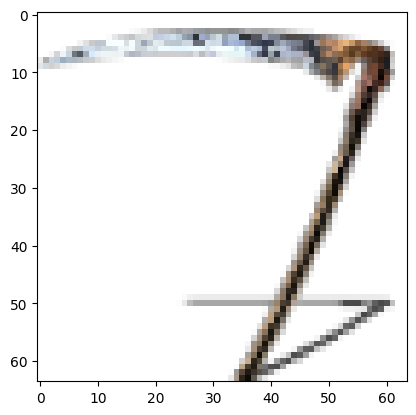

In [7]:
# Weapon example

# Display one image as an example
dataiter = iter(weapons_train_loader)
images = next(dataiter)
print(images[0].shape)
first_image = np.transpose(images[0], (1, 2, 0))
first_image = first_image / 2 + 0.5     # unnormalize

plt.imshow(first_image)
plt.show()

In [8]:
# Define the discriminator, returns a value between 0 and 1, a possibility.
class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(4, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )
        

    def forward(self, x):
        output = self.model(x)
        return output.view(-1, 1).squeeze(1)

In [9]:
class Generator(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(64, 4, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, z):
        return self.model(z)

In [20]:
# Create the generator, the discriminator and their respective optimizers.
generator = Generator().to(device)

discriminator = Discriminator().to(device)

genopt = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

discopt = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

criterion = nn.BCELoss()

In [21]:
def train_models():
    real_label = 1.0
    fake_label = 0.0

    # Training the models
    n_total_steps = len(weapons_train_loader)
    for epoch in range(num_epochs):
        for i, real in enumerate(weapons_train_loader):
            ### Train the discriminator: max log(D(x)) + log(1 - D(G(z))) ###

            # train with real images
            real = real.to(device)
            current_batch_size = real.shape[0]
            label1 = torch.full((current_batch_size, ), real_label, device=device)

            output_real = discriminator(real)
            real_error_d = criterion(output_real, label1)

            # train with fake images
            z = torch.randn(current_batch_size, latent_dim, 1, 1, device=device)
            fake = generator(z)
            label2 = torch.full((current_batch_size, ), fake_label, device=device)
            output_fake = discriminator(fake.detach())
            fake_error_d = criterion(output_fake, label2)
            err_d = (real_error_d + fake_error_d)

            discopt.zero_grad()
            err_d.backward()
            discopt.step()

            ### Train the generator: max log(D(G(z))) ###

            label3 = torch.full((current_batch_size, ), real_label, device=device) # fake labels become real labels for the generator to maximize the equation
            output_fake_2 = discriminator(fake)
            err_g = criterion(output_fake_2, label3)

            genopt.zero_grad()
            err_g.backward()
            genopt.step()


            if (i + 1) % 10 == 0:
                print(f'epoch {epoch + 1} / {num_epochs}, step {i + 1} / {n_total_steps}, gen_loss = {err_g.item():.4f}, disc_loss = {err_d.item():.4f}')
            

            
        # Sample an image from the generator
        discriminator.eval()    # Disable dropout and such
        generator.eval()

        z1 = (torch.randn(1, latent_dim, 1, 1)).to(device)

        image = generator(z1)[0].cpu().view(1, 4, 64, 64)
        print(image.shape)

        discriminator_output = discriminator(image.to(device))
        print(discriminator_output)

        # Display one image as an example (CIFAR)
        image = np.transpose(image.view(4, 64, 64).detach(), (1, 2, 0))
        image = image / 2 + 0.5    # unnormalize

        plt.imshow(image)
        plt.show()

        # # Show the image (MNIST)
        # pixels = image.detach().reshape((28, 28))
        # plt.imshow(pixels, cmap="gray")
        # plt.show()

        discriminator.train()
        generator.train()

epoch 1 / 200, step 10 / 12, gen_loss = 5.6638, disc_loss = 0.1009
torch.Size([1, 4, 64, 64])
tensor([0.3423], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 2 / 200, step 10 / 12, gen_loss = 8.8732, disc_loss = 0.0855
torch.Size([1, 4, 64, 64])
tensor([0.0826], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 3 / 200, step 10 / 12, gen_loss = 9.1641, disc_loss = 0.1763
torch.Size([1, 4, 64, 64])
tensor([0.0001], device='cuda:0', grad_fn=<SqueezeBackward1>)


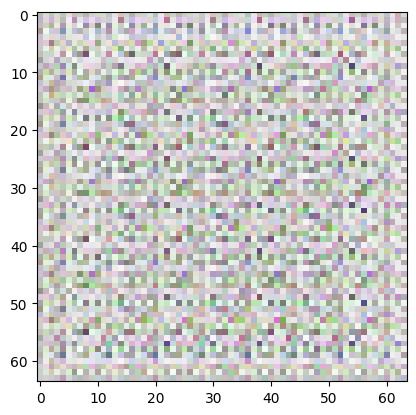

epoch 4 / 200, step 10 / 12, gen_loss = 16.9592, disc_loss = 0.7689
torch.Size([1, 4, 64, 64])
tensor([5.7780e-08], device='cuda:0', grad_fn=<SqueezeBackward1>)


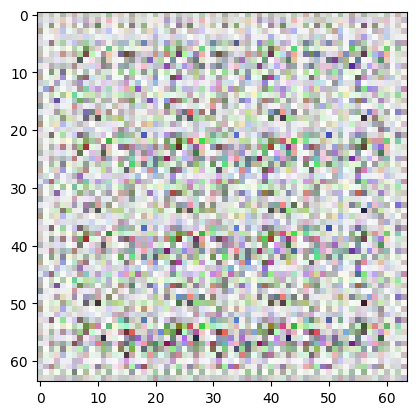

epoch 5 / 200, step 10 / 12, gen_loss = 17.5720, disc_loss = 0.0312
torch.Size([1, 4, 64, 64])
tensor([4.8249e-06], device='cuda:0', grad_fn=<SqueezeBackward1>)


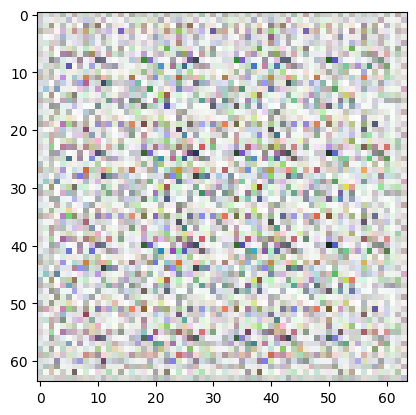

epoch 6 / 200, step 10 / 12, gen_loss = 14.7558, disc_loss = 0.0386
torch.Size([1, 4, 64, 64])
tensor([0.0003], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 7 / 200, step 10 / 12, gen_loss = 10.6387, disc_loss = 0.0328
torch.Size([1, 4, 64, 64])
tensor([0.0007], device='cuda:0', grad_fn=<SqueezeBackward1>)


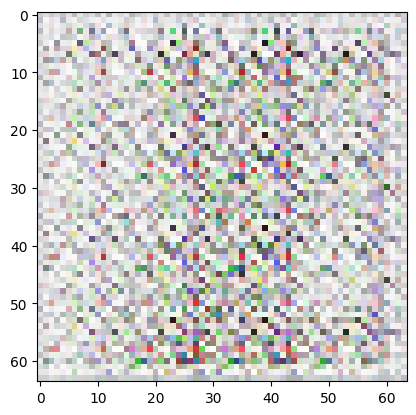

epoch 8 / 200, step 10 / 12, gen_loss = 7.5472, disc_loss = 0.0082
torch.Size([1, 4, 64, 64])
tensor([0.0200], device='cuda:0', grad_fn=<SqueezeBackward1>)


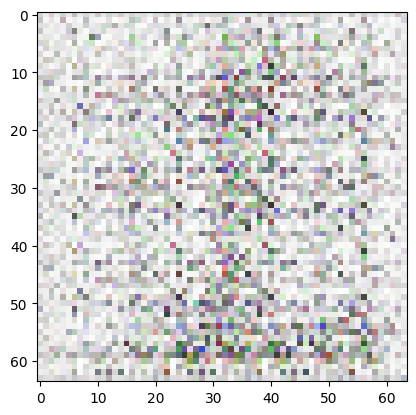

epoch 9 / 200, step 10 / 12, gen_loss = 4.2257, disc_loss = 0.2855
torch.Size([1, 4, 64, 64])
tensor([0.2743], device='cuda:0', grad_fn=<SqueezeBackward1>)


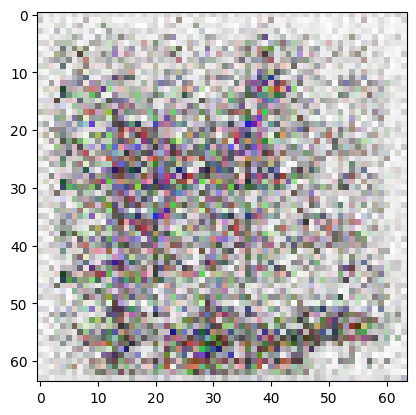

epoch 10 / 200, step 10 / 12, gen_loss = 4.5229, disc_loss = 0.4504
torch.Size([1, 4, 64, 64])
tensor([0.1325], device='cuda:0', grad_fn=<SqueezeBackward1>)


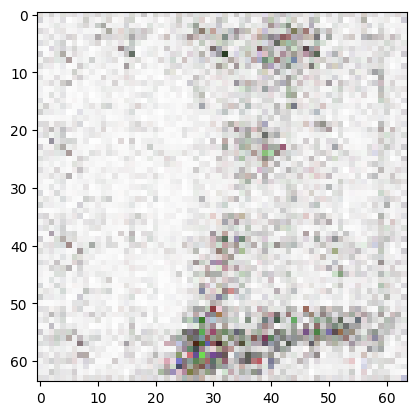

epoch 11 / 200, step 10 / 12, gen_loss = 4.7189, disc_loss = 0.3910
torch.Size([1, 4, 64, 64])
tensor([0.8153], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 12 / 200, step 10 / 12, gen_loss = 3.2357, disc_loss = 0.4728
torch.Size([1, 4, 64, 64])
tensor([0.3227], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 13 / 200, step 10 / 12, gen_loss = 4.7236, disc_loss = 0.4068
torch.Size([1, 4, 64, 64])
tensor([0.0063], device='cuda:0', grad_fn=<SqueezeBackward1>)


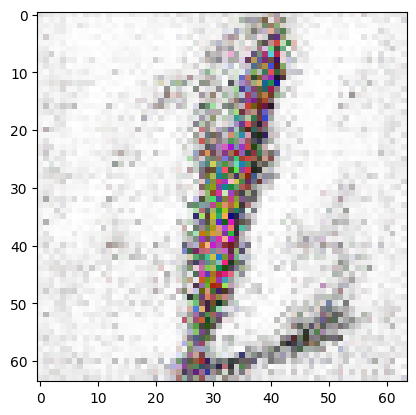

epoch 14 / 200, step 10 / 12, gen_loss = 4.4849, disc_loss = 0.5542
torch.Size([1, 4, 64, 64])
tensor([0.2621], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 15 / 200, step 10 / 12, gen_loss = 4.2492, disc_loss = 0.4800
torch.Size([1, 4, 64, 64])
tensor([0.4064], device='cuda:0', grad_fn=<SqueezeBackward1>)


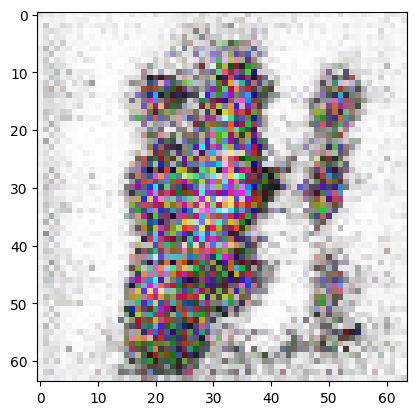

epoch 16 / 200, step 10 / 12, gen_loss = 3.2693, disc_loss = 0.6101
torch.Size([1, 4, 64, 64])
tensor([0.1357], device='cuda:0', grad_fn=<SqueezeBackward1>)


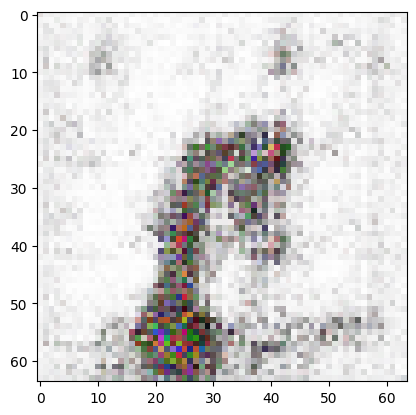

epoch 17 / 200, step 10 / 12, gen_loss = 1.1727, disc_loss = 0.5481
torch.Size([1, 4, 64, 64])
tensor([0.6436], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 18 / 200, step 10 / 12, gen_loss = 3.7547, disc_loss = 0.2539
torch.Size([1, 4, 64, 64])
tensor([0.9076], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 19 / 200, step 10 / 12, gen_loss = 3.2713, disc_loss = 0.2788
torch.Size([1, 4, 64, 64])
tensor([0.0411], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 20 / 200, step 10 / 12, gen_loss = 0.2111, disc_loss = 1.1732
torch.Size([1, 4, 64, 64])
tensor([9.9293e-05], device='cuda:0', grad_fn=<SqueezeBackward1>)


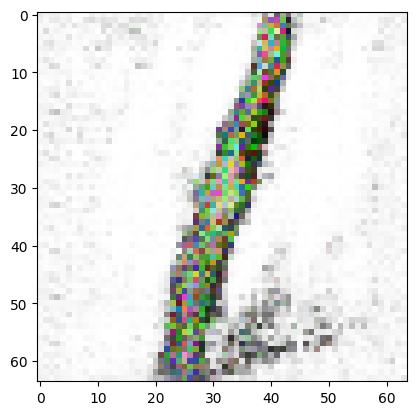

epoch 21 / 200, step 10 / 12, gen_loss = 2.3564, disc_loss = 0.7665
torch.Size([1, 4, 64, 64])
tensor([0.0242], device='cuda:0', grad_fn=<SqueezeBackward1>)


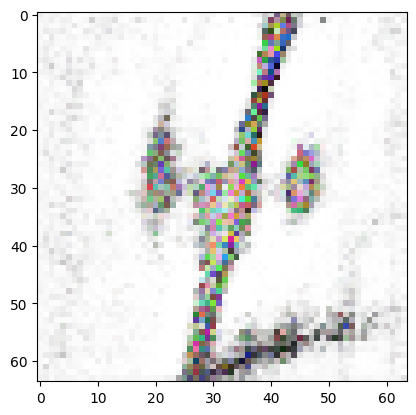

epoch 22 / 200, step 10 / 12, gen_loss = 3.4373, disc_loss = 0.3741
torch.Size([1, 4, 64, 64])
tensor([0.0009], device='cuda:0', grad_fn=<SqueezeBackward1>)


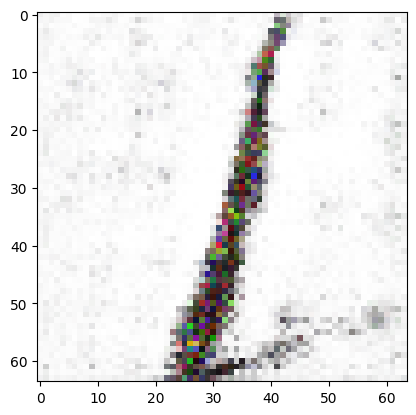

epoch 23 / 200, step 10 / 12, gen_loss = 4.0403, disc_loss = 0.0610
torch.Size([1, 4, 64, 64])
tensor([0.0613], device='cuda:0', grad_fn=<SqueezeBackward1>)


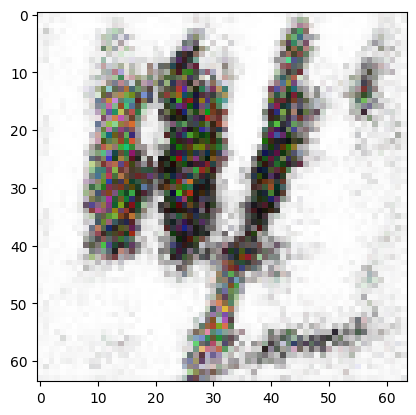

epoch 24 / 200, step 10 / 12, gen_loss = 3.0124, disc_loss = 0.4982
torch.Size([1, 4, 64, 64])
tensor([0.0235], device='cuda:0', grad_fn=<SqueezeBackward1>)


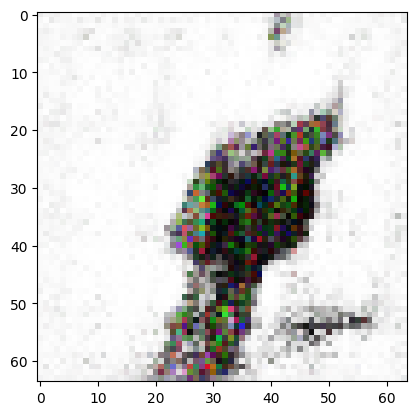

epoch 25 / 200, step 10 / 12, gen_loss = 3.1527, disc_loss = 0.3439
torch.Size([1, 4, 64, 64])
tensor([0.3847], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 26 / 200, step 10 / 12, gen_loss = 2.8764, disc_loss = 0.3381
torch.Size([1, 4, 64, 64])
tensor([0.1754], device='cuda:0', grad_fn=<SqueezeBackward1>)


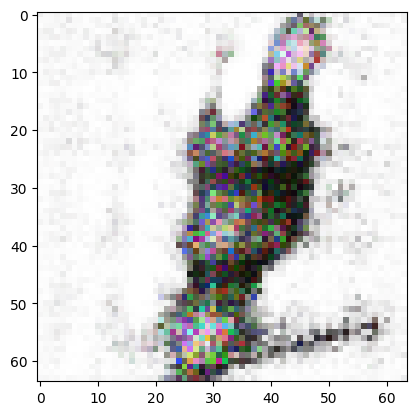

epoch 27 / 200, step 10 / 12, gen_loss = 5.0125, disc_loss = 0.6544
torch.Size([1, 4, 64, 64])
tensor([0.4784], device='cuda:0', grad_fn=<SqueezeBackward1>)


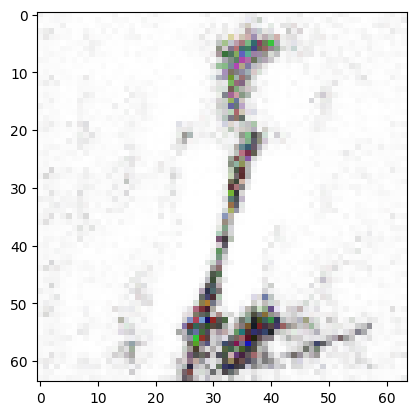

epoch 28 / 200, step 10 / 12, gen_loss = 2.4981, disc_loss = 0.4903
torch.Size([1, 4, 64, 64])
tensor([0.0013], device='cuda:0', grad_fn=<SqueezeBackward1>)


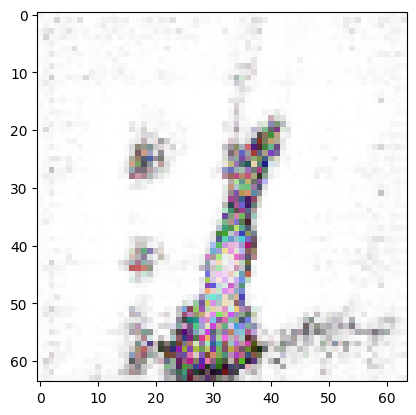

epoch 29 / 200, step 10 / 12, gen_loss = 4.1953, disc_loss = 0.5145
torch.Size([1, 4, 64, 64])
tensor([0.3107], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 30 / 200, step 10 / 12, gen_loss = 3.3288, disc_loss = 1.3431
torch.Size([1, 4, 64, 64])
tensor([0.0851], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 31 / 200, step 10 / 12, gen_loss = 3.7472, disc_loss = 0.6476
torch.Size([1, 4, 64, 64])
tensor([0.0425], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 32 / 200, step 10 / 12, gen_loss = 1.9072, disc_loss = 0.5477
torch.Size([1, 4, 64, 64])
tensor([0.0629], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 33 / 200, step 10 / 12, gen_loss = 4.9422, disc_loss = 0.2048
torch.Size([1, 4, 64, 64])
tensor([0.0807], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 34 / 200, step 10 / 12, gen_loss = 5.4442, disc_loss = 0.1725
torch.Size([1, 4, 64, 64])
tensor([0.7122], device='cuda:0', grad_fn=<SqueezeBackward1>)


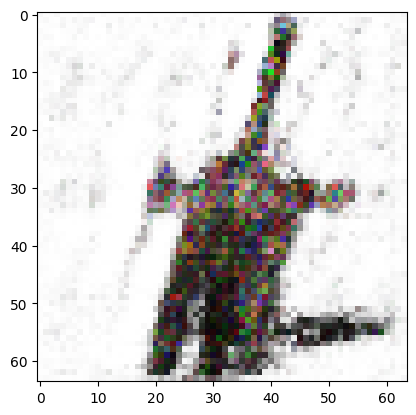

epoch 35 / 200, step 10 / 12, gen_loss = 5.7014, disc_loss = 0.1514
torch.Size([1, 4, 64, 64])
tensor([0.0003], device='cuda:0', grad_fn=<SqueezeBackward1>)


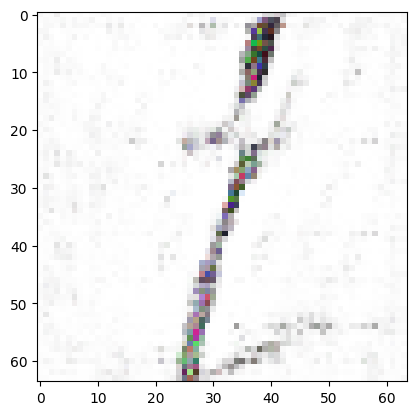

epoch 36 / 200, step 10 / 12, gen_loss = 3.9936, disc_loss = 0.4986
torch.Size([1, 4, 64, 64])
tensor([0.1374], device='cuda:0', grad_fn=<SqueezeBackward1>)


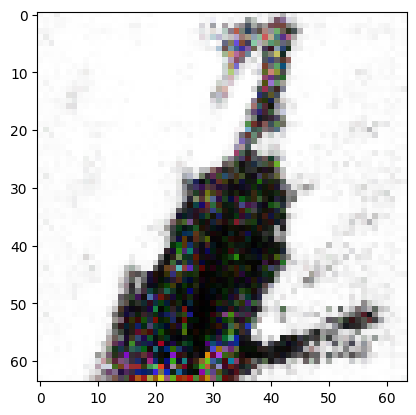

epoch 37 / 200, step 10 / 12, gen_loss = 4.4156, disc_loss = 0.2199
torch.Size([1, 4, 64, 64])
tensor([0.1915], device='cuda:0', grad_fn=<SqueezeBackward1>)


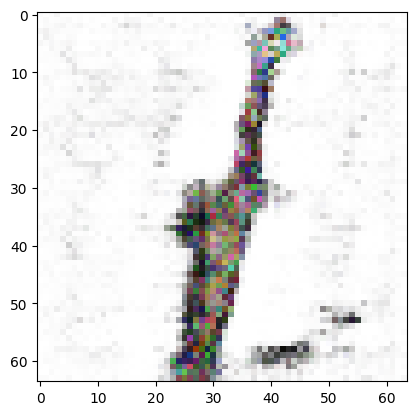

epoch 38 / 200, step 10 / 12, gen_loss = 5.8862, disc_loss = 0.4105
torch.Size([1, 4, 64, 64])
tensor([0.3418], device='cuda:0', grad_fn=<SqueezeBackward1>)


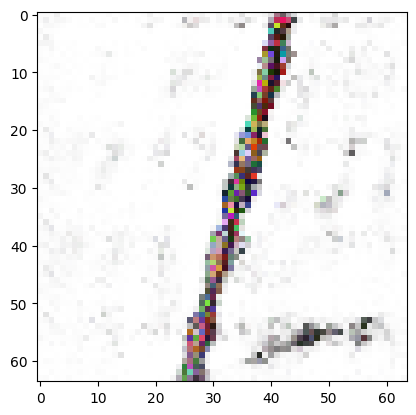

epoch 39 / 200, step 10 / 12, gen_loss = 0.6187, disc_loss = 1.6535
torch.Size([1, 4, 64, 64])
tensor([0.4739], device='cuda:0', grad_fn=<SqueezeBackward1>)


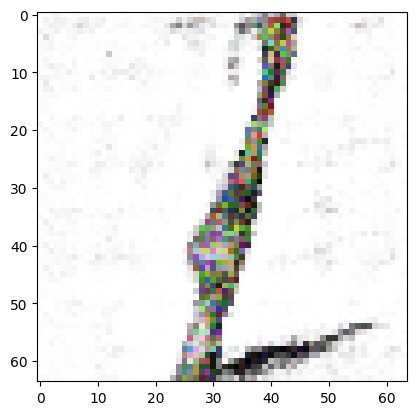

epoch 40 / 200, step 10 / 12, gen_loss = 5.2870, disc_loss = 0.2360
torch.Size([1, 4, 64, 64])
tensor([0.1016], device='cuda:0', grad_fn=<SqueezeBackward1>)


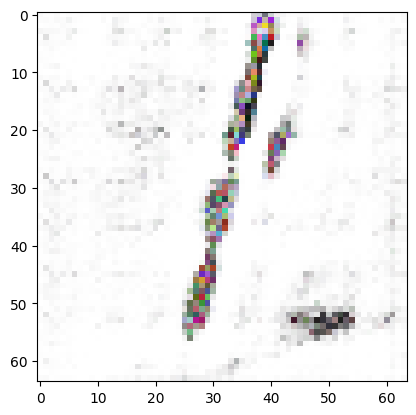

epoch 41 / 200, step 10 / 12, gen_loss = 5.0557, disc_loss = 0.0763
torch.Size([1, 4, 64, 64])
tensor([0.0245], device='cuda:0', grad_fn=<SqueezeBackward1>)


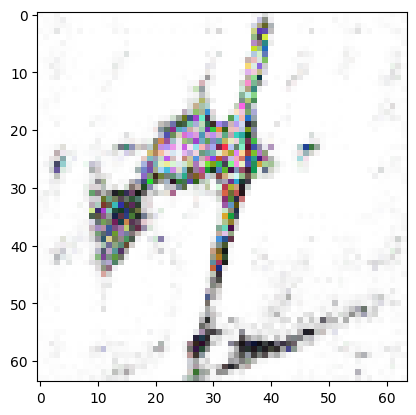

epoch 42 / 200, step 10 / 12, gen_loss = 4.3181, disc_loss = 0.0834
torch.Size([1, 4, 64, 64])
tensor([0.0097], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 43 / 200, step 10 / 12, gen_loss = 4.3312, disc_loss = 0.1002
torch.Size([1, 4, 64, 64])
tensor([0.2526], device='cuda:0', grad_fn=<SqueezeBackward1>)


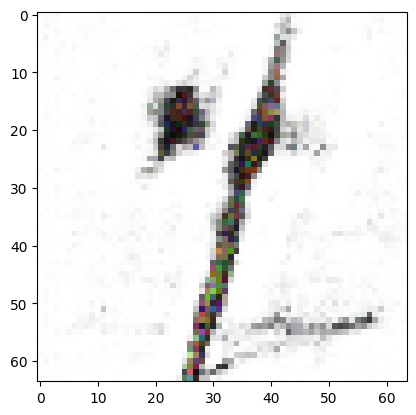

epoch 44 / 200, step 10 / 12, gen_loss = 5.1104, disc_loss = 0.2543
torch.Size([1, 4, 64, 64])
tensor([0.0065], device='cuda:0', grad_fn=<SqueezeBackward1>)


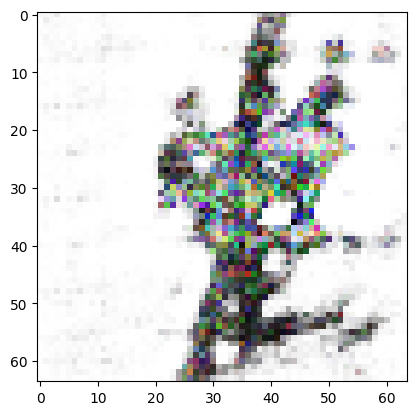

epoch 45 / 200, step 10 / 12, gen_loss = 6.0815, disc_loss = 0.3191
torch.Size([1, 4, 64, 64])
tensor([0.2407], device='cuda:0', grad_fn=<SqueezeBackward1>)


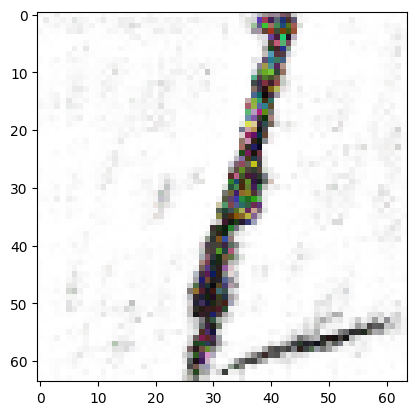

epoch 46 / 200, step 10 / 12, gen_loss = 2.0437, disc_loss = 2.7735
torch.Size([1, 4, 64, 64])
tensor([0.0036], device='cuda:0', grad_fn=<SqueezeBackward1>)


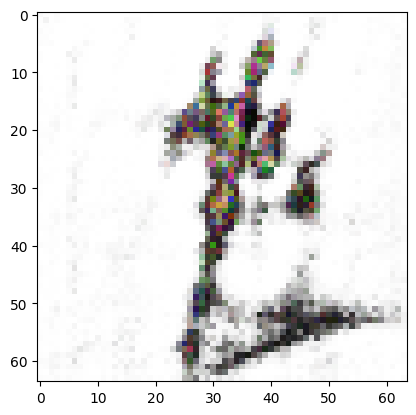

epoch 47 / 200, step 10 / 12, gen_loss = 6.3318, disc_loss = 0.1404
torch.Size([1, 4, 64, 64])
tensor([0.5786], device='cuda:0', grad_fn=<SqueezeBackward1>)


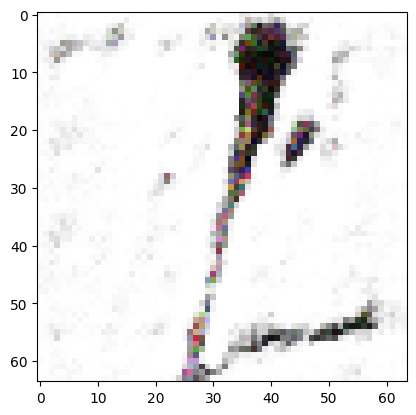

epoch 48 / 200, step 10 / 12, gen_loss = 3.2256, disc_loss = 0.8180
torch.Size([1, 4, 64, 64])
tensor([0.0062], device='cuda:0', grad_fn=<SqueezeBackward1>)


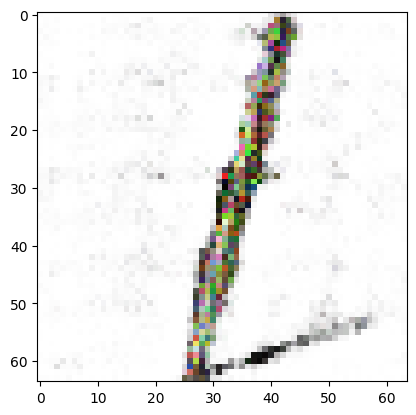

epoch 49 / 200, step 10 / 12, gen_loss = 4.4089, disc_loss = 0.0768
torch.Size([1, 4, 64, 64])
tensor([0.0473], device='cuda:0', grad_fn=<SqueezeBackward1>)


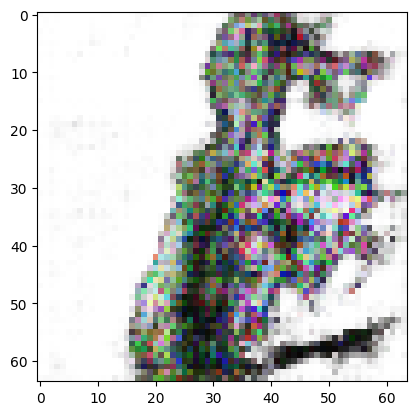

epoch 50 / 200, step 10 / 12, gen_loss = 4.7373, disc_loss = 0.1277
torch.Size([1, 4, 64, 64])
tensor([0.1813], device='cuda:0', grad_fn=<SqueezeBackward1>)


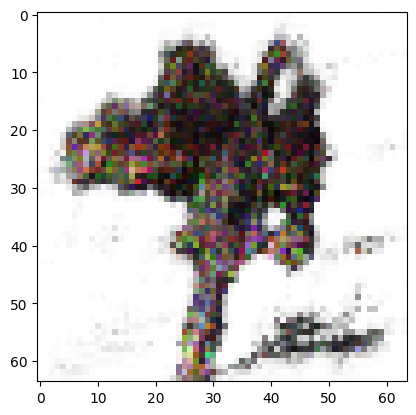

epoch 51 / 200, step 10 / 12, gen_loss = 5.3031, disc_loss = 0.0670
torch.Size([1, 4, 64, 64])
tensor([0.5750], device='cuda:0', grad_fn=<SqueezeBackward1>)


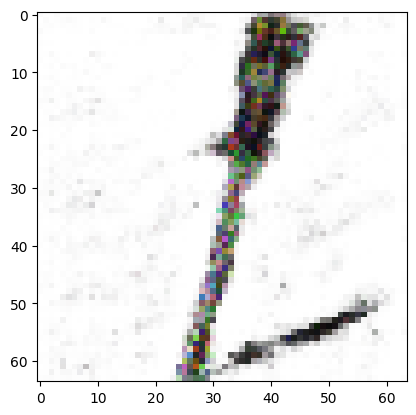

epoch 52 / 200, step 10 / 12, gen_loss = 6.5815, disc_loss = 0.0247
torch.Size([1, 4, 64, 64])
tensor([0.0151], device='cuda:0', grad_fn=<SqueezeBackward1>)


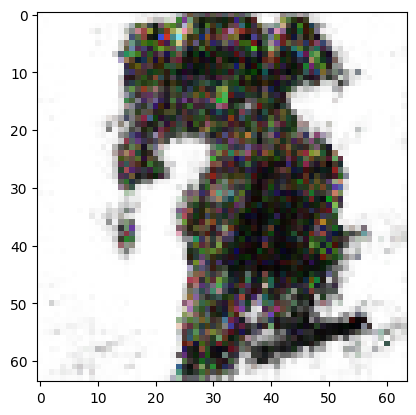

epoch 53 / 200, step 10 / 12, gen_loss = 4.6019, disc_loss = 0.0613
torch.Size([1, 4, 64, 64])
tensor([0.0135], device='cuda:0', grad_fn=<SqueezeBackward1>)


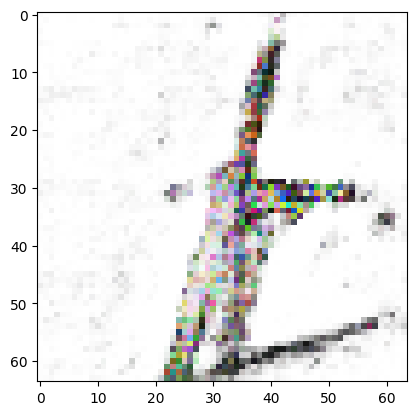

epoch 54 / 200, step 10 / 12, gen_loss = 5.9179, disc_loss = 0.0266
torch.Size([1, 4, 64, 64])
tensor([0.3712], device='cuda:0', grad_fn=<SqueezeBackward1>)


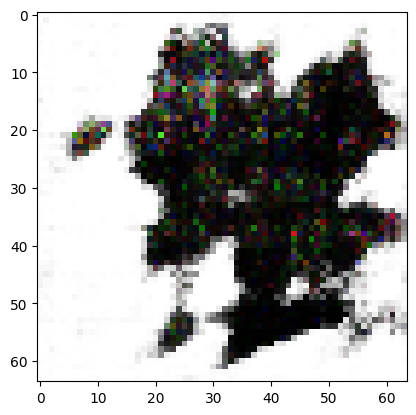

epoch 55 / 200, step 10 / 12, gen_loss = 5.1861, disc_loss = 0.0586
torch.Size([1, 4, 64, 64])
tensor([0.0143], device='cuda:0', grad_fn=<SqueezeBackward1>)


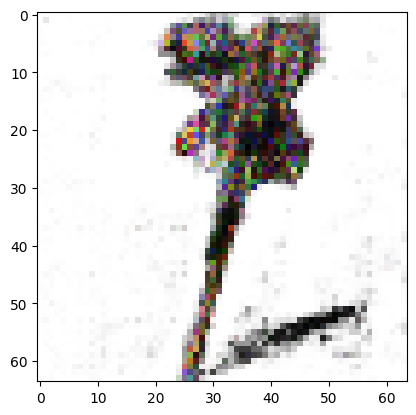

epoch 56 / 200, step 10 / 12, gen_loss = 6.8824, disc_loss = 0.3587
torch.Size([1, 4, 64, 64])
tensor([0.0074], device='cuda:0', grad_fn=<SqueezeBackward1>)


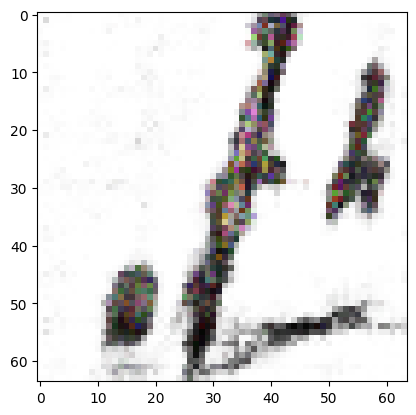

epoch 57 / 200, step 10 / 12, gen_loss = 5.9300, disc_loss = 0.2644
torch.Size([1, 4, 64, 64])
tensor([0.0212], device='cuda:0', grad_fn=<SqueezeBackward1>)


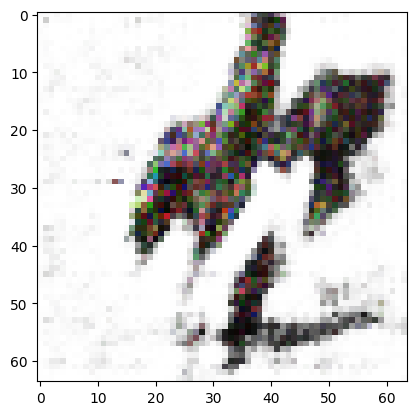

epoch 58 / 200, step 10 / 12, gen_loss = 6.3091, disc_loss = 0.2469
torch.Size([1, 4, 64, 64])
tensor([0.2375], device='cuda:0', grad_fn=<SqueezeBackward1>)


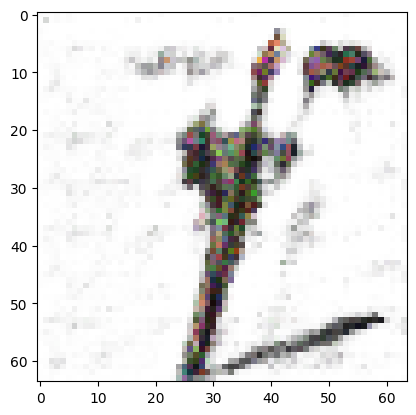

epoch 59 / 200, step 10 / 12, gen_loss = 0.7948, disc_loss = 2.9352
torch.Size([1, 4, 64, 64])
tensor([0.0986], device='cuda:0', grad_fn=<SqueezeBackward1>)


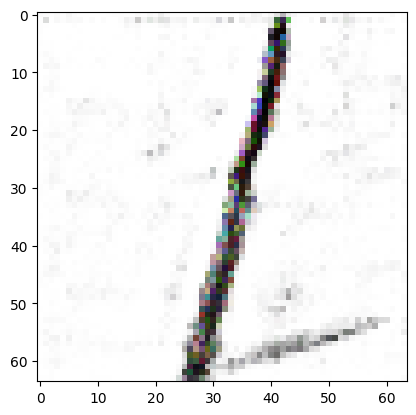

epoch 60 / 200, step 10 / 12, gen_loss = 4.6841, disc_loss = 0.3743
torch.Size([1, 4, 64, 64])
tensor([0.0303], device='cuda:0', grad_fn=<SqueezeBackward1>)


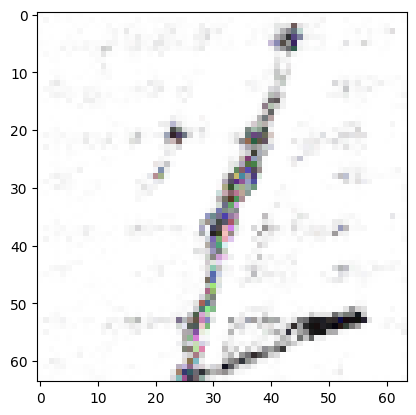

epoch 61 / 200, step 10 / 12, gen_loss = 4.2060, disc_loss = 0.3452
torch.Size([1, 4, 64, 64])
tensor([0.2595], device='cuda:0', grad_fn=<SqueezeBackward1>)


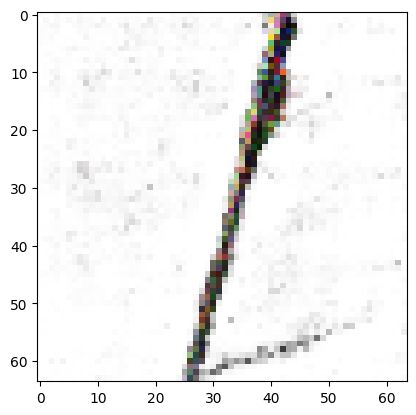

epoch 62 / 200, step 10 / 12, gen_loss = 6.4178, disc_loss = 1.4500
torch.Size([1, 4, 64, 64])
tensor([0.0474], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 63 / 200, step 10 / 12, gen_loss = 4.7194, disc_loss = 0.3905
torch.Size([1, 4, 64, 64])
tensor([0.3133], device='cuda:0', grad_fn=<SqueezeBackward1>)


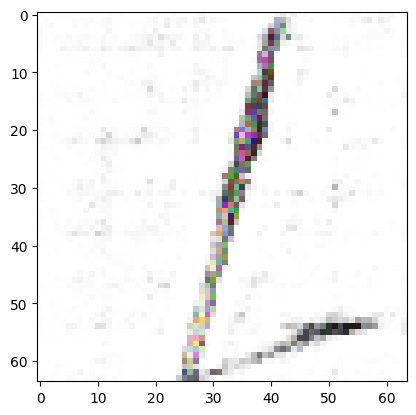

epoch 64 / 200, step 10 / 12, gen_loss = 6.1233, disc_loss = 0.1724
torch.Size([1, 4, 64, 64])
tensor([0.2852], device='cuda:0', grad_fn=<SqueezeBackward1>)


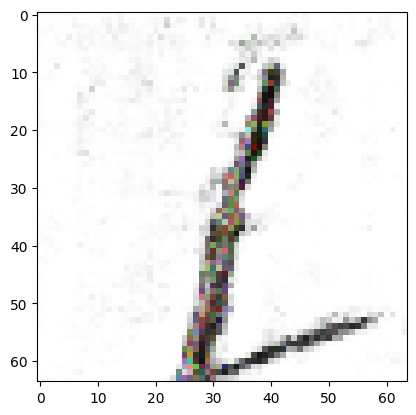

epoch 65 / 200, step 10 / 12, gen_loss = 4.5018, disc_loss = 0.2536
torch.Size([1, 4, 64, 64])
tensor([0.0279], device='cuda:0', grad_fn=<SqueezeBackward1>)


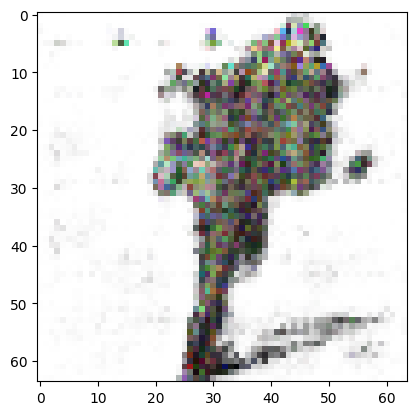

epoch 66 / 200, step 10 / 12, gen_loss = 3.8177, disc_loss = 0.1317
torch.Size([1, 4, 64, 64])
tensor([0.0160], device='cuda:0', grad_fn=<SqueezeBackward1>)


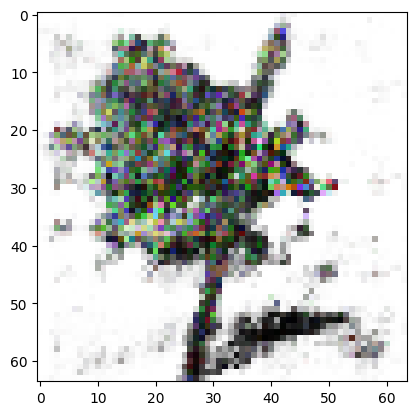

epoch 67 / 200, step 10 / 12, gen_loss = 5.5205, disc_loss = 0.0984
torch.Size([1, 4, 64, 64])
tensor([4.4397e-05], device='cuda:0', grad_fn=<SqueezeBackward1>)


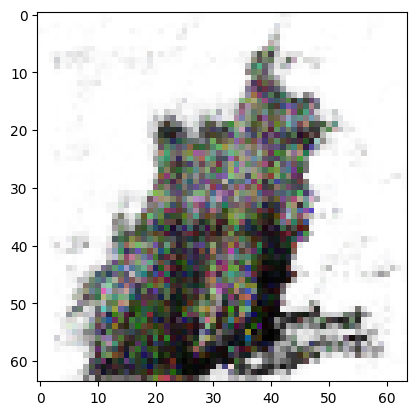

epoch 68 / 200, step 10 / 12, gen_loss = 6.5986, disc_loss = 0.2487
torch.Size([1, 4, 64, 64])
tensor([0.0468], device='cuda:0', grad_fn=<SqueezeBackward1>)


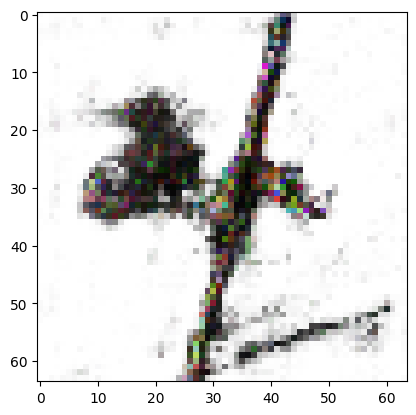

epoch 69 / 200, step 10 / 12, gen_loss = 6.1330, disc_loss = 0.0556
torch.Size([1, 4, 64, 64])
tensor([0.2007], device='cuda:0', grad_fn=<SqueezeBackward1>)


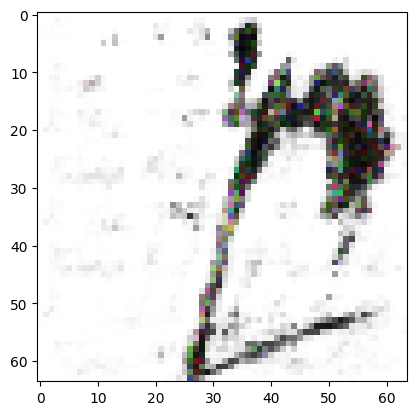

epoch 70 / 200, step 10 / 12, gen_loss = 5.3885, disc_loss = 0.1166
torch.Size([1, 4, 64, 64])
tensor([0.0730], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 71 / 200, step 10 / 12, gen_loss = 4.5608, disc_loss = 0.0927
torch.Size([1, 4, 64, 64])
tensor([0.2214], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 72 / 200, step 10 / 12, gen_loss = 5.3031, disc_loss = 0.0323
torch.Size([1, 4, 64, 64])
tensor([0.3430], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 73 / 200, step 10 / 12, gen_loss = 5.3375, disc_loss = 0.0370
torch.Size([1, 4, 64, 64])
tensor([0.6186], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 74 / 200, step 10 / 12, gen_loss = 4.2874, disc_loss = 0.0736
torch.Size([1, 4, 64, 64])
tensor([0.0299], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 75 / 200, step 10 / 12, gen_loss = 7.2774, disc_loss = 0.1416
torch.Size([1, 4, 64, 64])
tensor([0.0562], device='cuda:0', grad_fn=<SqueezeBackward1>)


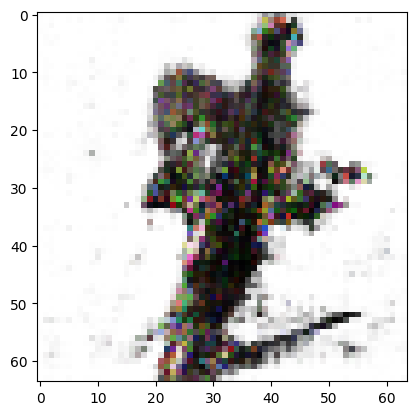

epoch 76 / 200, step 10 / 12, gen_loss = 5.4642, disc_loss = 0.0510
torch.Size([1, 4, 64, 64])
tensor([0.1401], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 77 / 200, step 10 / 12, gen_loss = 8.5052, disc_loss = 0.0590
torch.Size([1, 4, 64, 64])
tensor([0.0204], device='cuda:0', grad_fn=<SqueezeBackward1>)


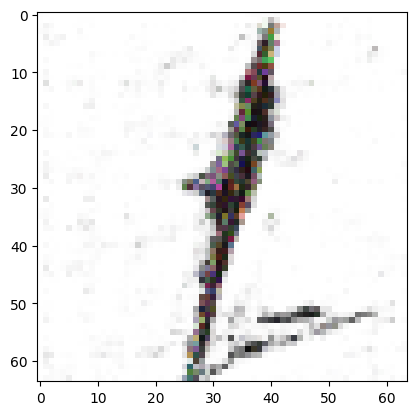

epoch 78 / 200, step 10 / 12, gen_loss = 5.7984, disc_loss = 0.0858
torch.Size([1, 4, 64, 64])
tensor([0.3132], device='cuda:0', grad_fn=<SqueezeBackward1>)


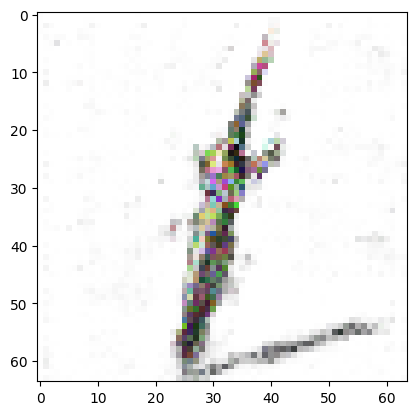

epoch 79 / 200, step 10 / 12, gen_loss = 5.9721, disc_loss = 0.0462
torch.Size([1, 4, 64, 64])
tensor([0.0238], device='cuda:0', grad_fn=<SqueezeBackward1>)


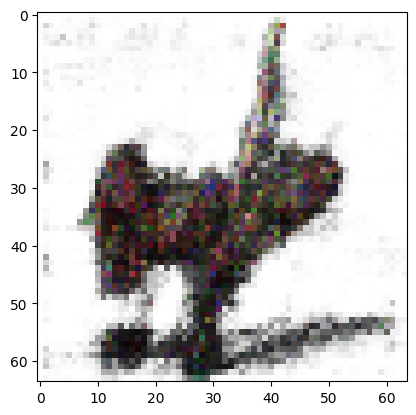

epoch 80 / 200, step 10 / 12, gen_loss = 4.3478, disc_loss = 0.0689
torch.Size([1, 4, 64, 64])
tensor([0.7598], device='cuda:0', grad_fn=<SqueezeBackward1>)


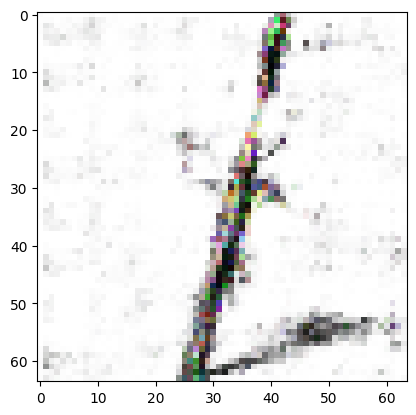

epoch 81 / 200, step 10 / 12, gen_loss = 3.8842, disc_loss = 0.1340
torch.Size([1, 4, 64, 64])
tensor([0.0013], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 82 / 200, step 10 / 12, gen_loss = 1.6536, disc_loss = 0.3504
torch.Size([1, 4, 64, 64])
tensor([0.0285], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 83 / 200, step 10 / 12, gen_loss = 6.0856, disc_loss = 0.1215
torch.Size([1, 4, 64, 64])
tensor([0.3020], device='cuda:0', grad_fn=<SqueezeBackward1>)


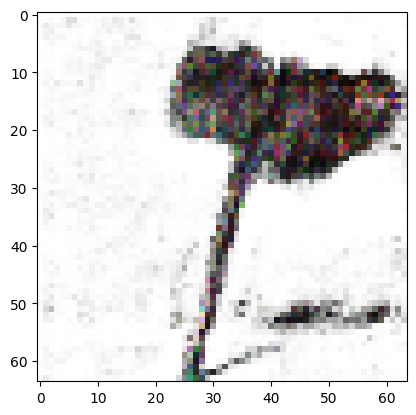

epoch 84 / 200, step 10 / 12, gen_loss = 12.3915, disc_loss = 0.4729
torch.Size([1, 4, 64, 64])
tensor([0.5758], device='cuda:0', grad_fn=<SqueezeBackward1>)


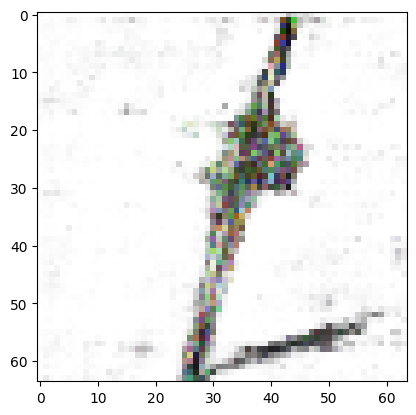

epoch 85 / 200, step 10 / 12, gen_loss = 8.5398, disc_loss = 0.2961
torch.Size([1, 4, 64, 64])
tensor([0.9999], device='cuda:0', grad_fn=<SqueezeBackward1>)


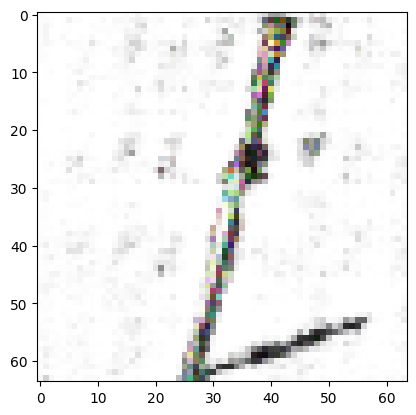

epoch 86 / 200, step 10 / 12, gen_loss = 3.7519, disc_loss = 0.3811
torch.Size([1, 4, 64, 64])
tensor([0.4875], device='cuda:0', grad_fn=<SqueezeBackward1>)


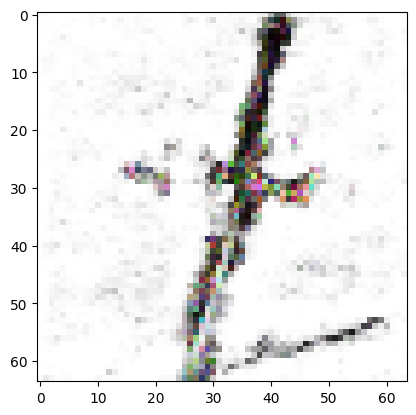

epoch 87 / 200, step 10 / 12, gen_loss = 6.4584, disc_loss = 0.0553
torch.Size([1, 4, 64, 64])
tensor([0.0220], device='cuda:0', grad_fn=<SqueezeBackward1>)


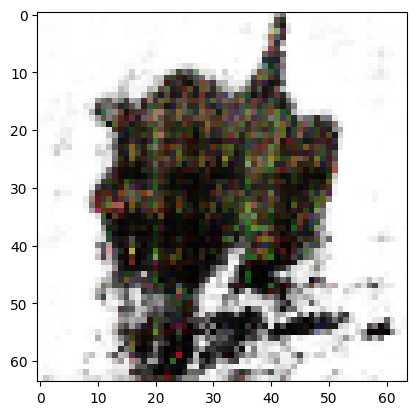

epoch 88 / 200, step 10 / 12, gen_loss = 4.7250, disc_loss = 0.1096
torch.Size([1, 4, 64, 64])
tensor([0.3065], device='cuda:0', grad_fn=<SqueezeBackward1>)


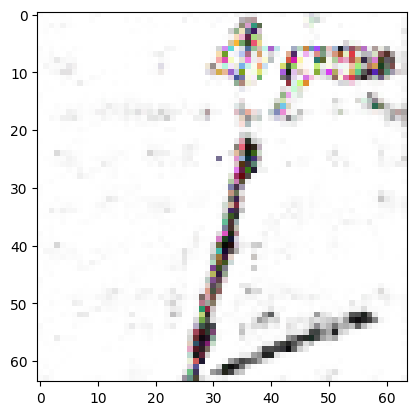

epoch 89 / 200, step 10 / 12, gen_loss = 3.2710, disc_loss = 0.2055
torch.Size([1, 4, 64, 64])
tensor([0.0008], device='cuda:0', grad_fn=<SqueezeBackward1>)


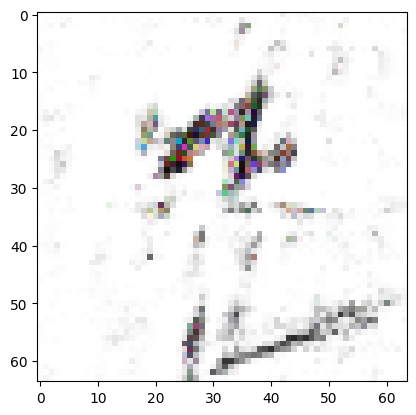

epoch 90 / 200, step 10 / 12, gen_loss = 6.1023, disc_loss = 0.3179
torch.Size([1, 4, 64, 64])
tensor([0.0014], device='cuda:0', grad_fn=<SqueezeBackward1>)


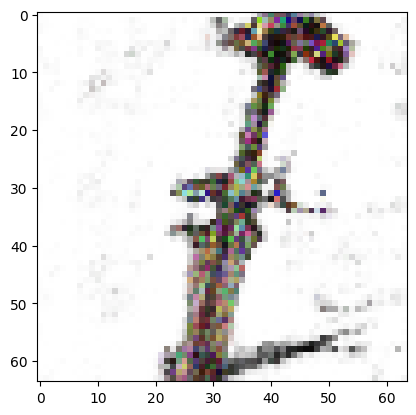

epoch 91 / 200, step 10 / 12, gen_loss = 4.2116, disc_loss = 0.0629
torch.Size([1, 4, 64, 64])
tensor([0.0148], device='cuda:0', grad_fn=<SqueezeBackward1>)


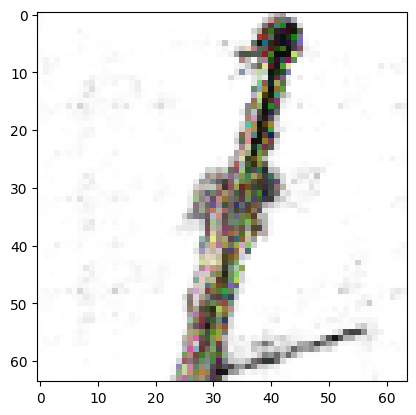

epoch 92 / 200, step 10 / 12, gen_loss = 3.7354, disc_loss = 0.1576
torch.Size([1, 4, 64, 64])
tensor([0.5824], device='cuda:0', grad_fn=<SqueezeBackward1>)


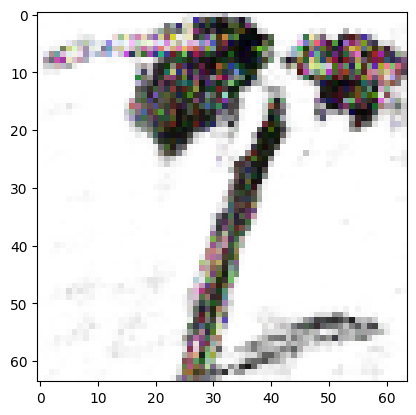

epoch 93 / 200, step 10 / 12, gen_loss = 4.6183, disc_loss = 0.0762
torch.Size([1, 4, 64, 64])
tensor([0.0290], device='cuda:0', grad_fn=<SqueezeBackward1>)


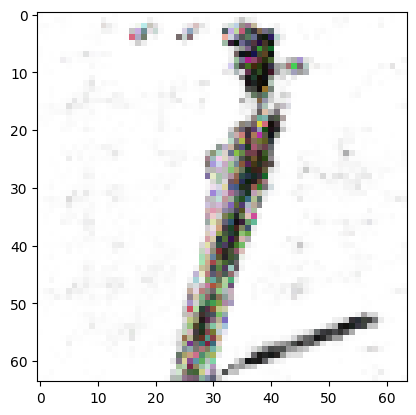

epoch 94 / 200, step 10 / 12, gen_loss = 5.6044, disc_loss = 0.1210
torch.Size([1, 4, 64, 64])
tensor([0.0325], device='cuda:0', grad_fn=<SqueezeBackward1>)


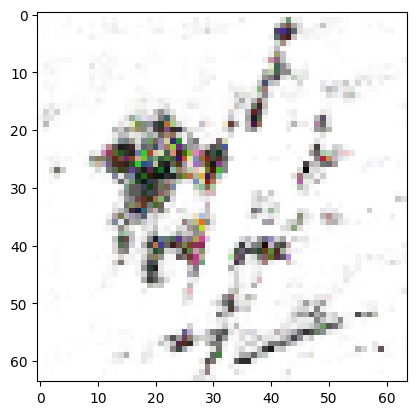

epoch 95 / 200, step 10 / 12, gen_loss = 12.7128, disc_loss = 0.4502
torch.Size([1, 4, 64, 64])
tensor([0.0005], device='cuda:0', grad_fn=<SqueezeBackward1>)


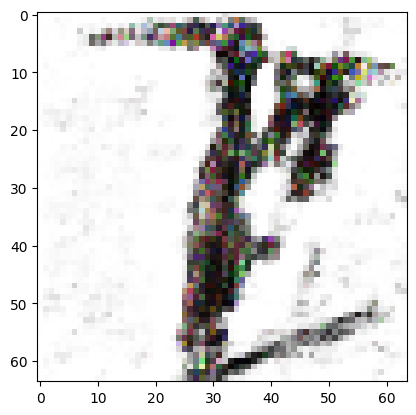

epoch 96 / 200, step 10 / 12, gen_loss = 5.0635, disc_loss = 0.1142
torch.Size([1, 4, 64, 64])
tensor([0.0064], device='cuda:0', grad_fn=<SqueezeBackward1>)


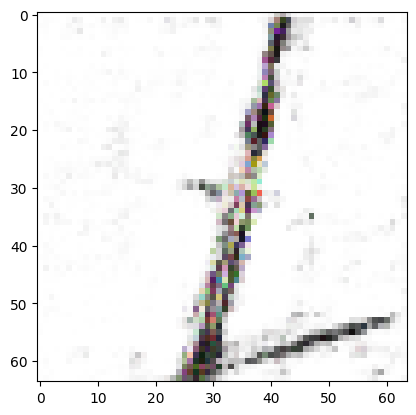

epoch 97 / 200, step 10 / 12, gen_loss = 5.5507, disc_loss = 0.0703
torch.Size([1, 4, 64, 64])
tensor([0.0769], device='cuda:0', grad_fn=<SqueezeBackward1>)


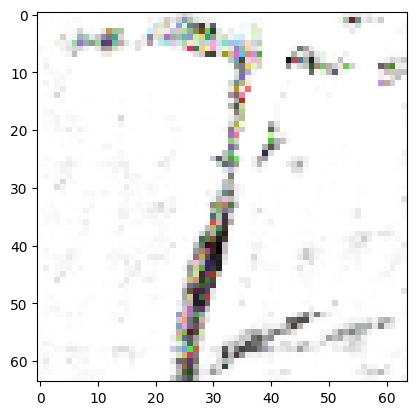

epoch 98 / 200, step 10 / 12, gen_loss = 5.2228, disc_loss = 0.0234
torch.Size([1, 4, 64, 64])
tensor([0.0484], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 99 / 200, step 10 / 12, gen_loss = 7.4355, disc_loss = 0.0286
torch.Size([1, 4, 64, 64])
tensor([0.3895], device='cuda:0', grad_fn=<SqueezeBackward1>)


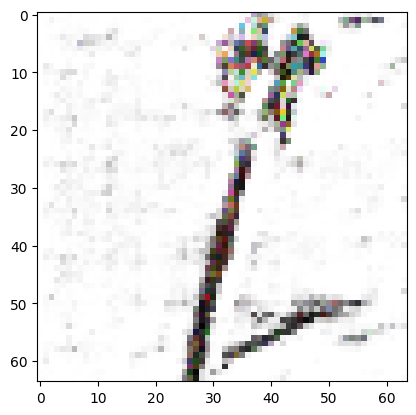

epoch 100 / 200, step 10 / 12, gen_loss = 6.3819, disc_loss = 0.0438
torch.Size([1, 4, 64, 64])
tensor([0.4838], device='cuda:0', grad_fn=<SqueezeBackward1>)


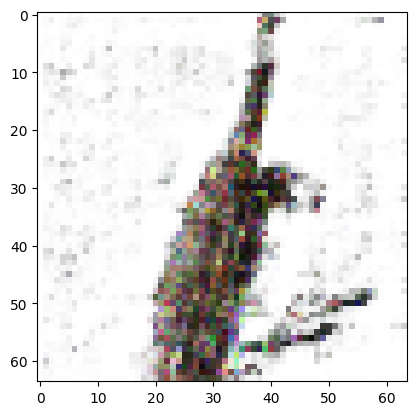

epoch 101 / 200, step 10 / 12, gen_loss = 5.9824, disc_loss = 0.0171
torch.Size([1, 4, 64, 64])
tensor([0.0541], device='cuda:0', grad_fn=<SqueezeBackward1>)


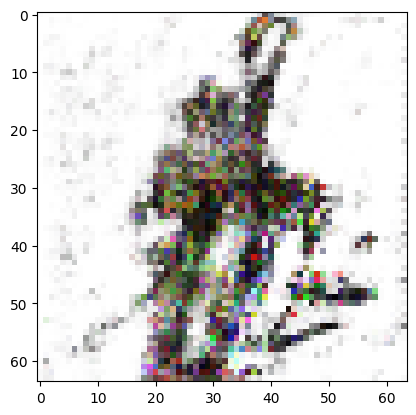

epoch 102 / 200, step 10 / 12, gen_loss = 4.8565, disc_loss = 0.0356
torch.Size([1, 4, 64, 64])
tensor([0.0648], device='cuda:0', grad_fn=<SqueezeBackward1>)


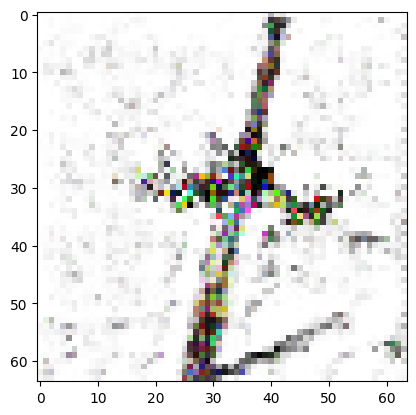

epoch 103 / 200, step 10 / 12, gen_loss = 5.9313, disc_loss = 0.0250
torch.Size([1, 4, 64, 64])
tensor([0.2677], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 104 / 200, step 10 / 12, gen_loss = 13.0165, disc_loss = 0.0364
torch.Size([1, 4, 64, 64])
tensor([0.2219], device='cuda:0', grad_fn=<SqueezeBackward1>)


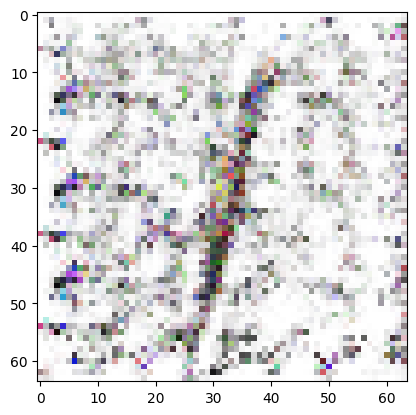

epoch 105 / 200, step 10 / 12, gen_loss = 6.9887, disc_loss = 0.1617
torch.Size([1, 4, 64, 64])
tensor([0.0002], device='cuda:0', grad_fn=<SqueezeBackward1>)


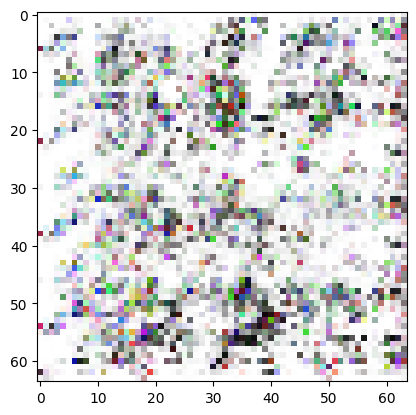

epoch 106 / 200, step 10 / 12, gen_loss = 14.5767, disc_loss = 0.0003
torch.Size([1, 4, 64, 64])
tensor([0.3320], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 107 / 200, step 10 / 12, gen_loss = 21.4459, disc_loss = 0.2469
torch.Size([1, 4, 64, 64])
tensor([1.4495e-11], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 108 / 200, step 10 / 12, gen_loss = 21.9918, disc_loss = 0.0137
torch.Size([1, 4, 64, 64])
tensor([1.5720e-09], device='cuda:0', grad_fn=<SqueezeBackward1>)


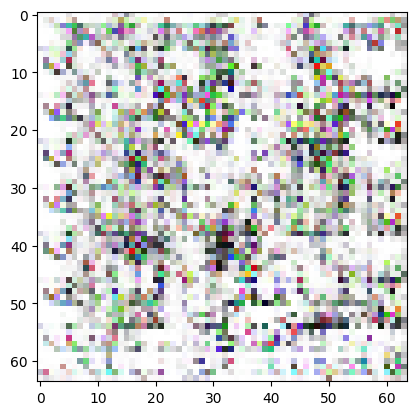

epoch 109 / 200, step 10 / 12, gen_loss = 9.9786, disc_loss = 0.0440
torch.Size([1, 4, 64, 64])
tensor([0.1837], device='cuda:0', grad_fn=<SqueezeBackward1>)


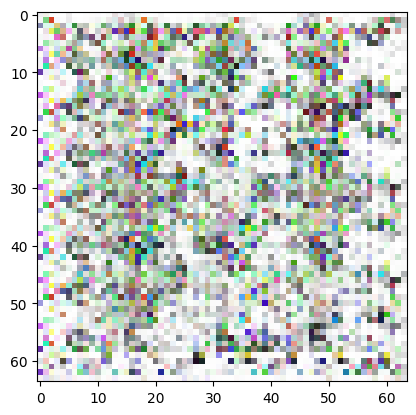

epoch 110 / 200, step 10 / 12, gen_loss = 9.2177, disc_loss = 0.0214
torch.Size([1, 4, 64, 64])
tensor([0.0032], device='cuda:0', grad_fn=<SqueezeBackward1>)


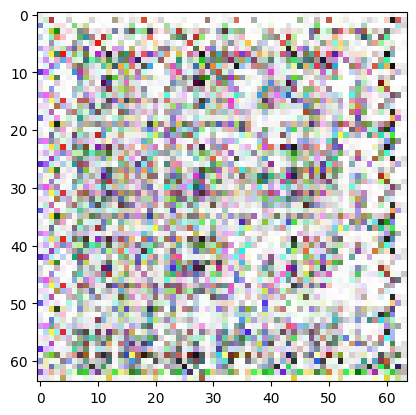

epoch 111 / 200, step 10 / 12, gen_loss = 20.6880, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([0.0017], device='cuda:0', grad_fn=<SqueezeBackward1>)


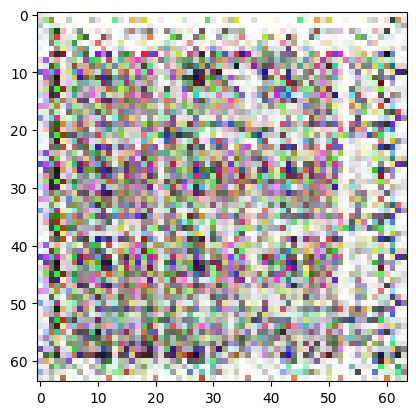

epoch 112 / 200, step 10 / 12, gen_loss = 35.8647, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([3.8501e-13], device='cuda:0', grad_fn=<SqueezeBackward1>)


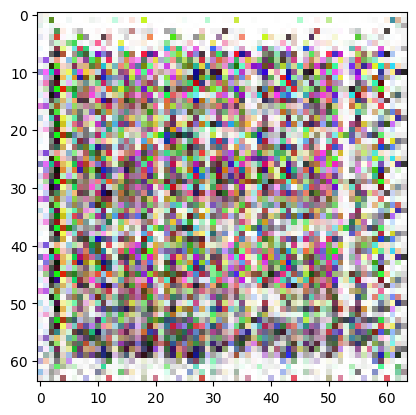

epoch 113 / 200, step 10 / 12, gen_loss = 35.7628, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([6.3083e-13], device='cuda:0', grad_fn=<SqueezeBackward1>)


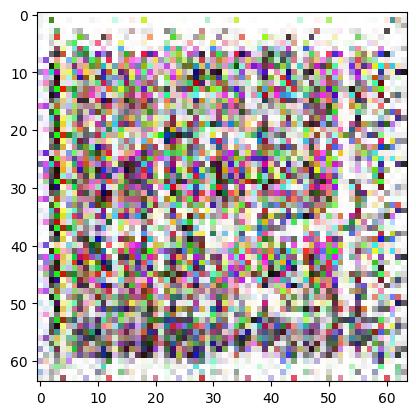

epoch 114 / 200, step 10 / 12, gen_loss = 35.8160, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([6.5656e-13], device='cuda:0', grad_fn=<SqueezeBackward1>)


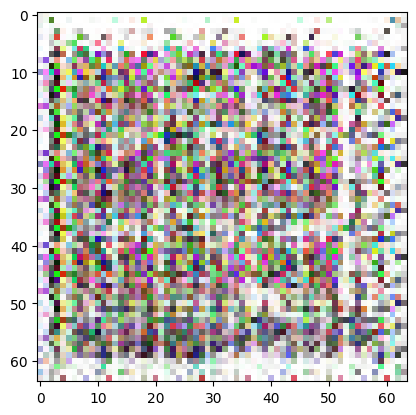

epoch 115 / 200, step 10 / 12, gen_loss = 35.4131, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([2.2226e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


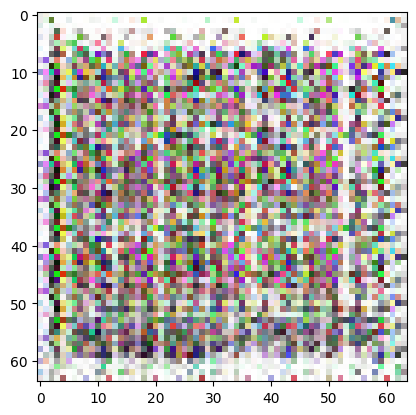

epoch 116 / 200, step 10 / 12, gen_loss = 35.4480, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([5.7129e-13], device='cuda:0', grad_fn=<SqueezeBackward1>)


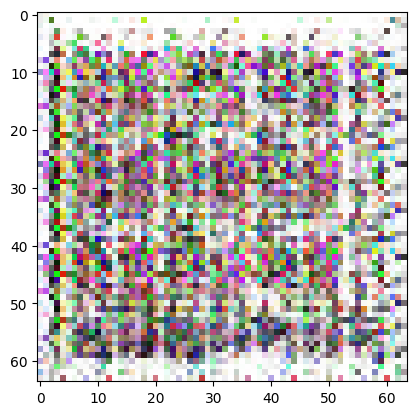

epoch 117 / 200, step 10 / 12, gen_loss = 35.3896, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([1.3701e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


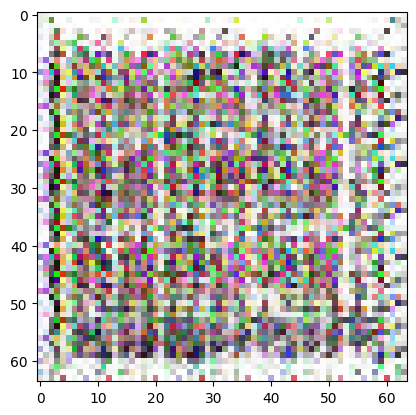

epoch 118 / 200, step 10 / 12, gen_loss = 35.3550, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([3.9039e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


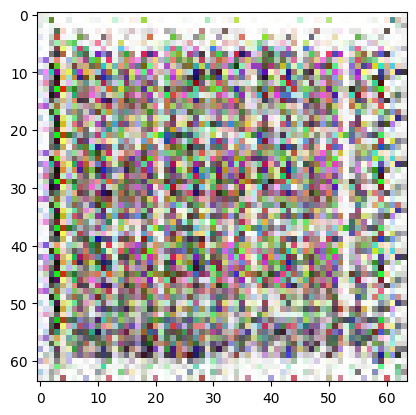

epoch 119 / 200, step 10 / 12, gen_loss = 35.4188, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([2.8139e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


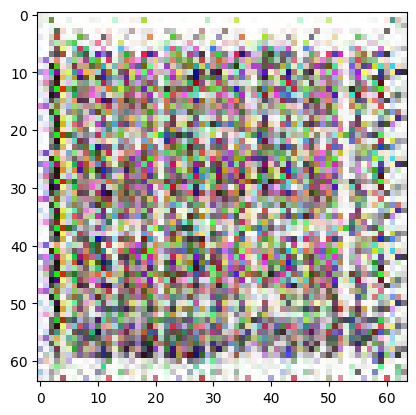

epoch 120 / 200, step 10 / 12, gen_loss = 35.3927, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([1.3194e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


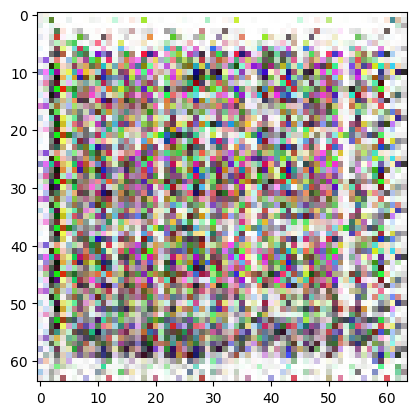

epoch 121 / 200, step 10 / 12, gen_loss = 35.3923, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([3.9143e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


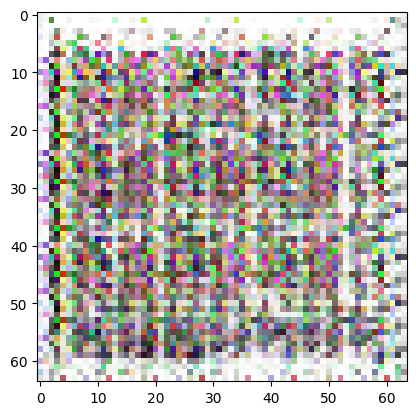

epoch 122 / 200, step 10 / 12, gen_loss = 35.2236, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([9.7588e-13], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 123 / 200, step 10 / 12, gen_loss = 35.3556, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([8.4930e-13], device='cuda:0', grad_fn=<SqueezeBackward1>)


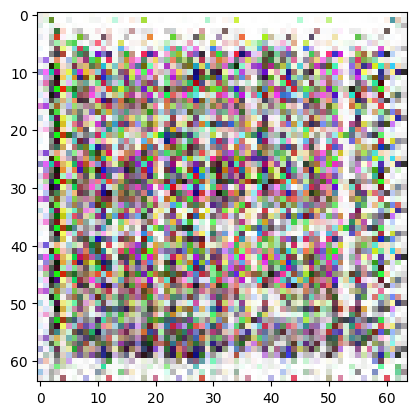

epoch 124 / 200, step 10 / 12, gen_loss = 35.3095, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([9.3031e-13], device='cuda:0', grad_fn=<SqueezeBackward1>)


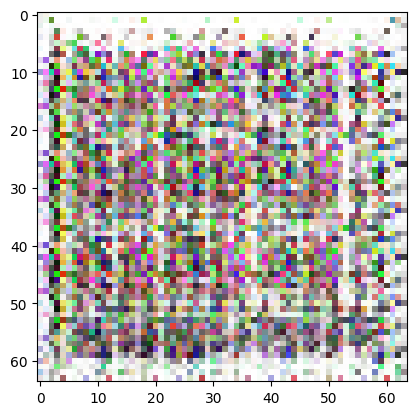

epoch 125 / 200, step 10 / 12, gen_loss = 35.3754, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([3.9570e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 126 / 200, step 10 / 12, gen_loss = 35.3478, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([3.1702e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 127 / 200, step 10 / 12, gen_loss = 35.2714, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([5.2826e-13], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 128 / 200, step 10 / 12, gen_loss = 35.2836, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([3.3259e-13], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 129 / 200, step 10 / 12, gen_loss = 35.2410, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([2.1860e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


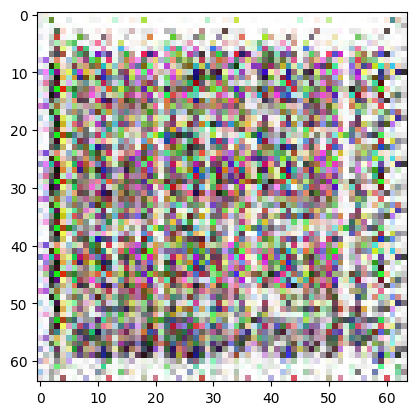

epoch 130 / 200, step 10 / 12, gen_loss = 35.3901, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([2.0323e-13], device='cuda:0', grad_fn=<SqueezeBackward1>)


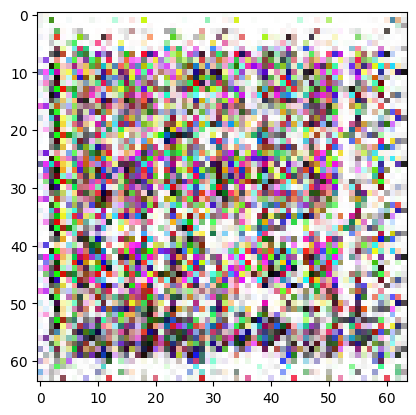

epoch 131 / 200, step 10 / 12, gen_loss = 35.2575, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([9.9105e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 132 / 200, step 10 / 12, gen_loss = 35.2460, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([5.9355e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


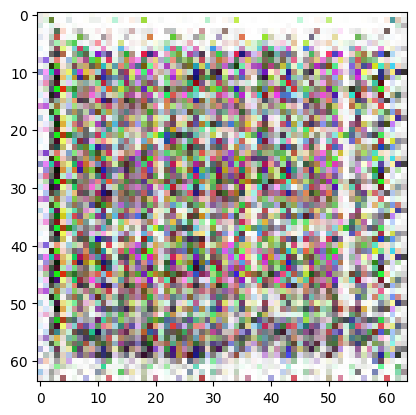

epoch 133 / 200, step 10 / 12, gen_loss = 35.1403, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([2.0192e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 134 / 200, step 10 / 12, gen_loss = 35.1676, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([2.0292e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 135 / 200, step 10 / 12, gen_loss = 35.0864, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([4.5004e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


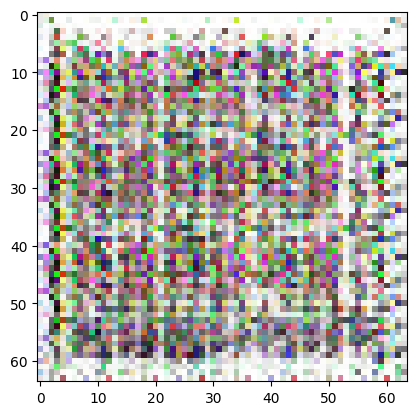

epoch 136 / 200, step 10 / 12, gen_loss = 35.0725, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([4.2354e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 137 / 200, step 10 / 12, gen_loss = 35.0808, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([3.8790e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


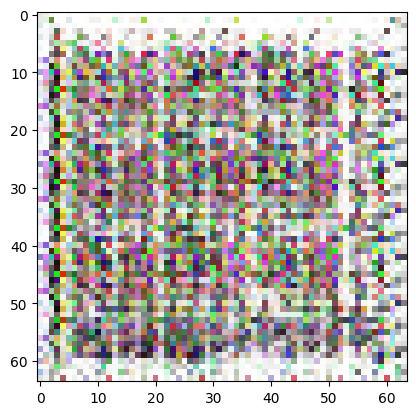

epoch 138 / 200, step 10 / 12, gen_loss = 35.2076, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([4.3549e-13], device='cuda:0', grad_fn=<SqueezeBackward1>)


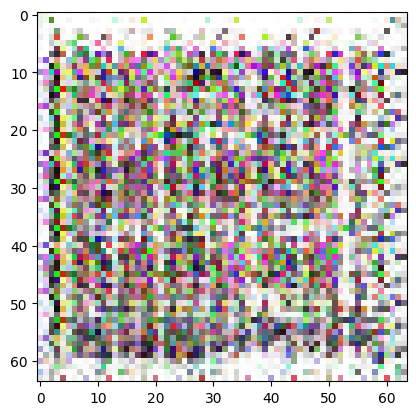

epoch 139 / 200, step 10 / 12, gen_loss = 35.0207, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([1.4428e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 140 / 200, step 10 / 12, gen_loss = 34.9798, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([4.4889e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 141 / 200, step 10 / 12, gen_loss = 35.0188, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([2.9883e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 142 / 200, step 10 / 12, gen_loss = 35.0155, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([2.4684e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 143 / 200, step 10 / 12, gen_loss = 34.9557, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([5.8670e-13], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 144 / 200, step 10 / 12, gen_loss = 35.0465, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([5.5672e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 145 / 200, step 10 / 12, gen_loss = 34.9547, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([2.8235e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 146 / 200, step 10 / 12, gen_loss = 34.9461, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([3.6085e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


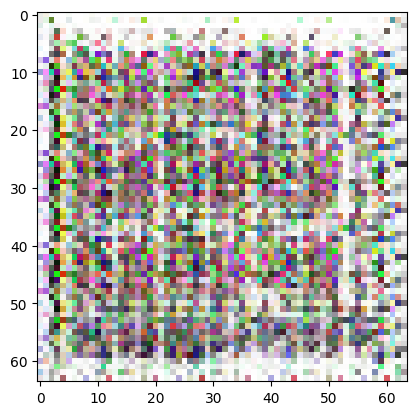

epoch 147 / 200, step 10 / 12, gen_loss = 34.8665, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([1.8176e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 148 / 200, step 10 / 12, gen_loss = 34.8668, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([4.8797e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 149 / 200, step 10 / 12, gen_loss = 34.6607, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([3.6821e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 150 / 200, step 10 / 12, gen_loss = 34.6920, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([5.5567e-13], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 151 / 200, step 10 / 12, gen_loss = 34.5473, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([1.9073e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


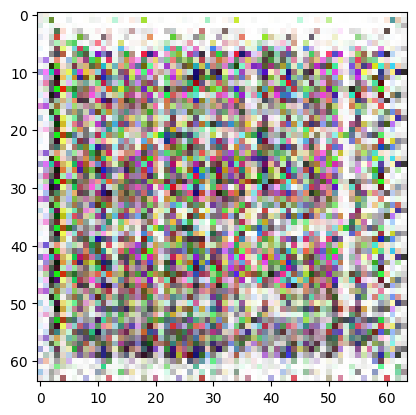

epoch 152 / 200, step 10 / 12, gen_loss = 34.7199, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([2.3041e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


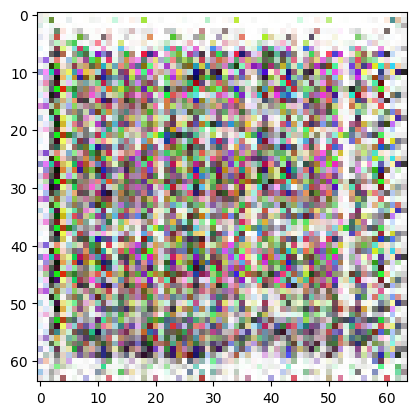

epoch 153 / 200, step 10 / 12, gen_loss = 34.7346, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([6.7149e-13], device='cuda:0', grad_fn=<SqueezeBackward1>)


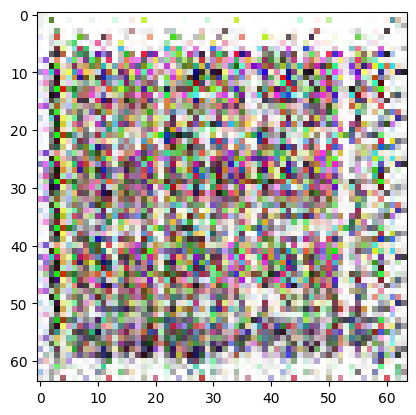

epoch 154 / 200, step 10 / 12, gen_loss = 34.6156, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([1.6583e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 155 / 200, step 10 / 12, gen_loss = 34.5191, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([1.9529e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 156 / 200, step 10 / 12, gen_loss = 34.5660, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([6.1893e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


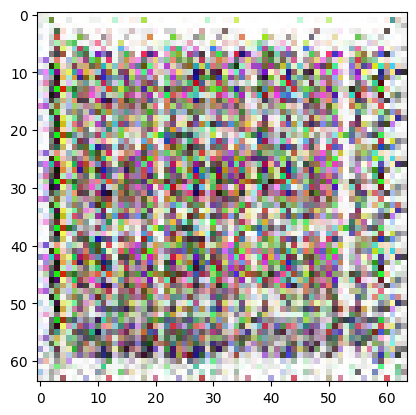

epoch 157 / 200, step 10 / 12, gen_loss = 34.5786, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([6.7680e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


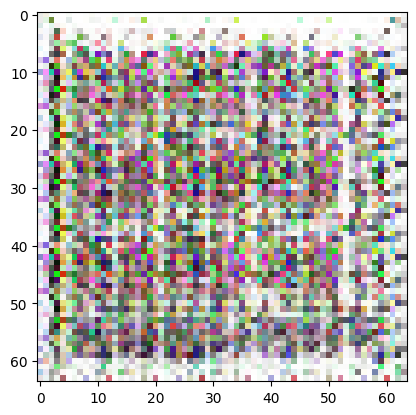

epoch 158 / 200, step 10 / 12, gen_loss = 34.5119, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([1.1902e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


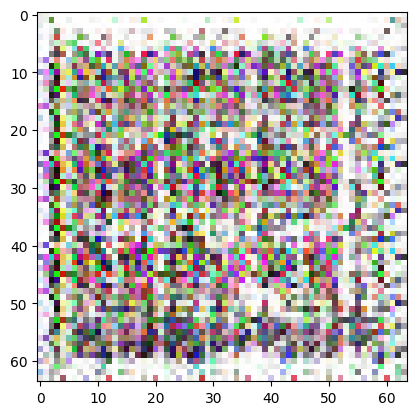

epoch 159 / 200, step 10 / 12, gen_loss = 34.3395, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([2.3927e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


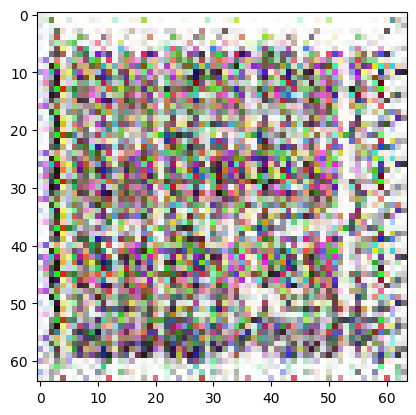

epoch 160 / 200, step 10 / 12, gen_loss = 34.3733, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([1.1659e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


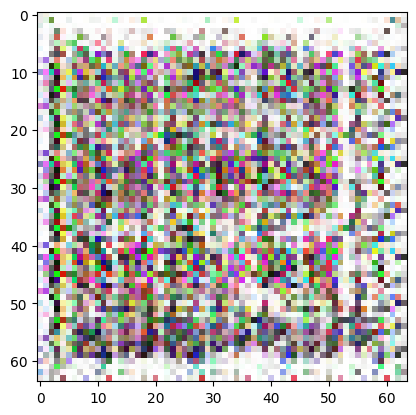

epoch 161 / 200, step 10 / 12, gen_loss = 34.3528, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([3.4505e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


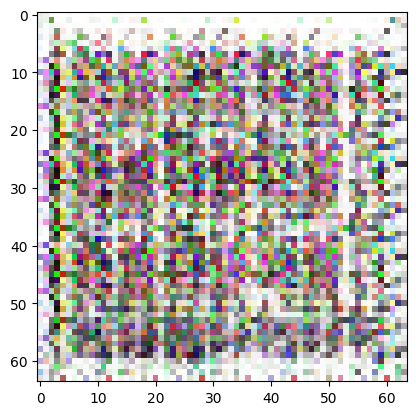

epoch 162 / 200, step 10 / 12, gen_loss = 34.0958, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([8.5178e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


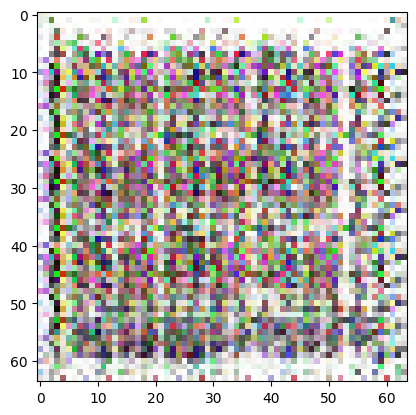

epoch 163 / 200, step 10 / 12, gen_loss = 34.0560, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([7.4969e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


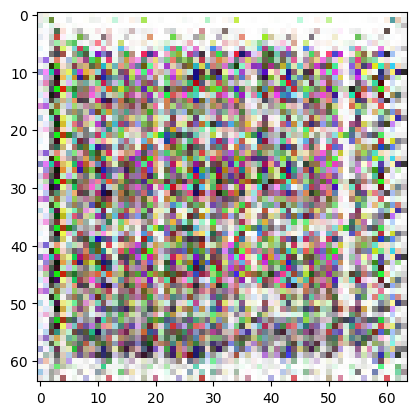

epoch 164 / 200, step 10 / 12, gen_loss = 34.1207, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([3.3906e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


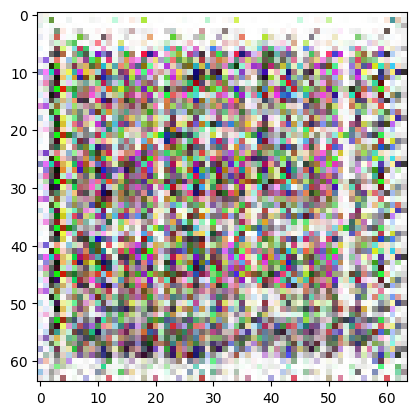

epoch 165 / 200, step 10 / 12, gen_loss = 34.0462, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([8.4515e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 166 / 200, step 10 / 12, gen_loss = 33.6981, disc_loss = 0.0001
torch.Size([1, 4, 64, 64])
tensor([4.2658e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 167 / 200, step 10 / 12, gen_loss = 33.7569, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([2.3087e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


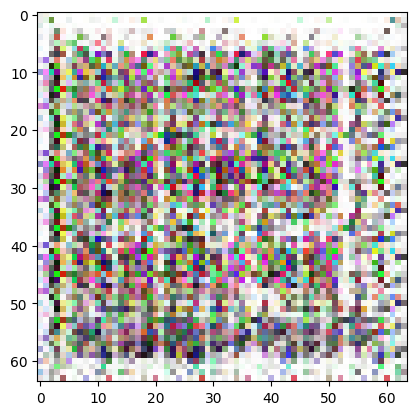

epoch 168 / 200, step 10 / 12, gen_loss = 33.7025, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([7.2018e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


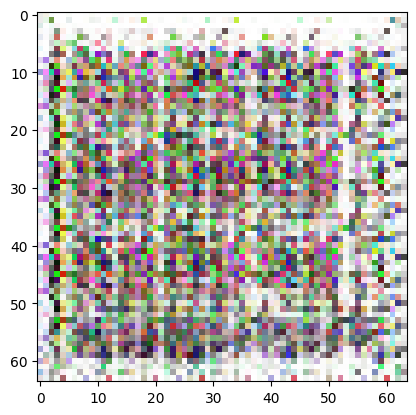

epoch 169 / 200, step 10 / 12, gen_loss = 33.4523, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([3.8380e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


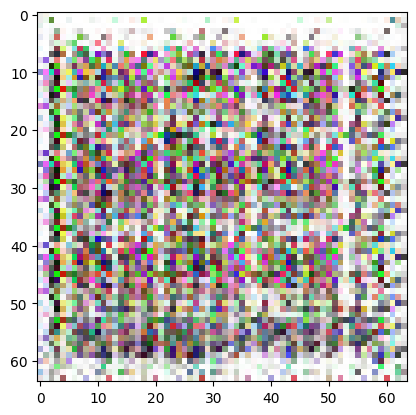

epoch 170 / 200, step 10 / 12, gen_loss = 33.3419, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([8.3985e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


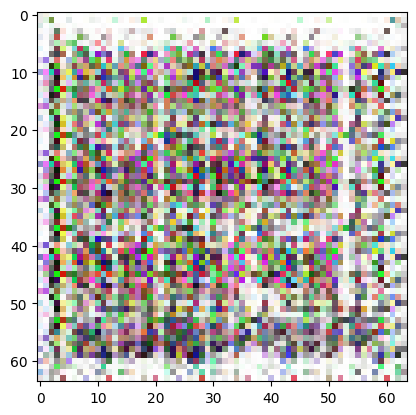

epoch 171 / 200, step 10 / 12, gen_loss = 33.1245, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([7.0283e-11], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 172 / 200, step 10 / 12, gen_loss = 32.8034, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([6.7040e-12], device='cuda:0', grad_fn=<SqueezeBackward1>)


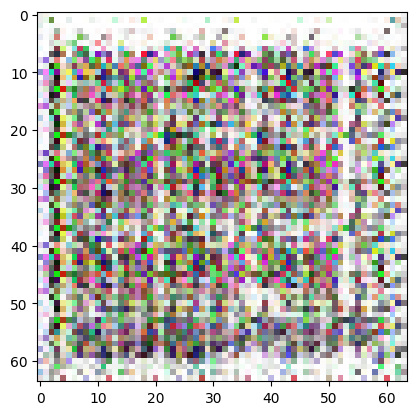

epoch 173 / 200, step 10 / 12, gen_loss = 32.3758, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([1.8886e-11], device='cuda:0', grad_fn=<SqueezeBackward1>)


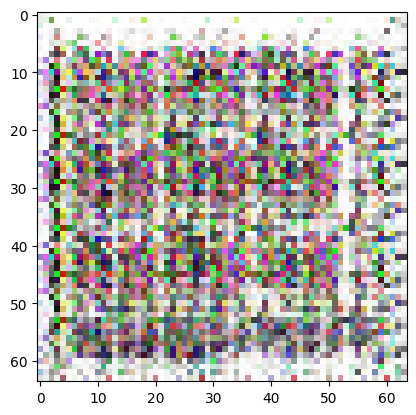

epoch 174 / 200, step 10 / 12, gen_loss = 31.2250, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([1.9550e-10], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 175 / 200, step 10 / 12, gen_loss = 26.3578, disc_loss = 0.0000
torch.Size([1, 4, 64, 64])
tensor([3.7520e-08], device='cuda:0', grad_fn=<SqueezeBackward1>)


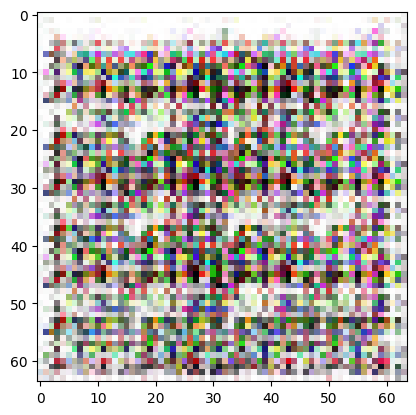

epoch 176 / 200, step 10 / 12, gen_loss = 29.0783, disc_loss = 0.0001
torch.Size([1, 4, 64, 64])
tensor([8.8614e-13], device='cuda:0', grad_fn=<SqueezeBackward1>)


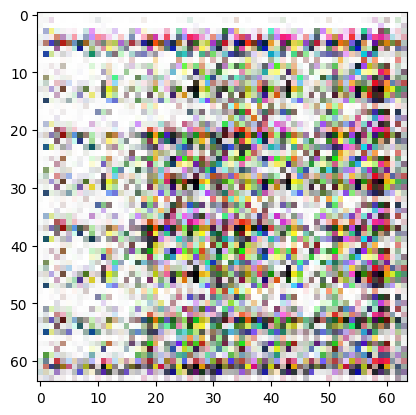

epoch 177 / 200, step 10 / 12, gen_loss = 8.9614, disc_loss = 0.0291
torch.Size([1, 4, 64, 64])
tensor([1.8511e-07], device='cuda:0', grad_fn=<SqueezeBackward1>)


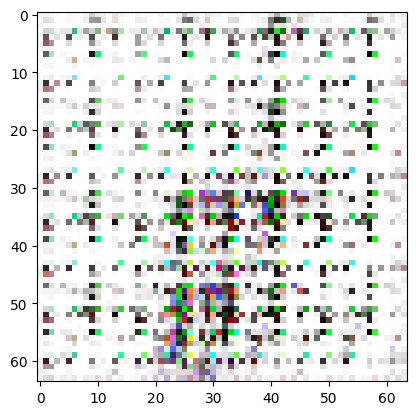

epoch 178 / 200, step 10 / 12, gen_loss = 2.7977, disc_loss = 0.2007
torch.Size([1, 4, 64, 64])
tensor([0.0140], device='cuda:0', grad_fn=<SqueezeBackward1>)


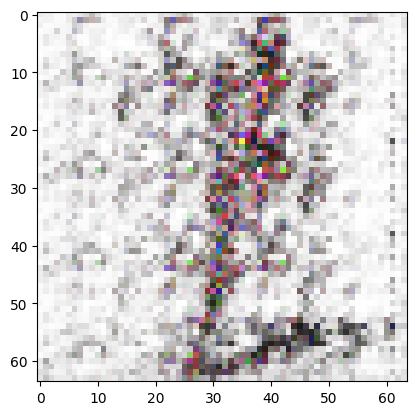

epoch 179 / 200, step 10 / 12, gen_loss = 5.7238, disc_loss = 0.0934
torch.Size([1, 4, 64, 64])
tensor([0.0058], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 180 / 200, step 10 / 12, gen_loss = 3.4954, disc_loss = 0.6064
torch.Size([1, 4, 64, 64])
tensor([0.0002], device='cuda:0', grad_fn=<SqueezeBackward1>)


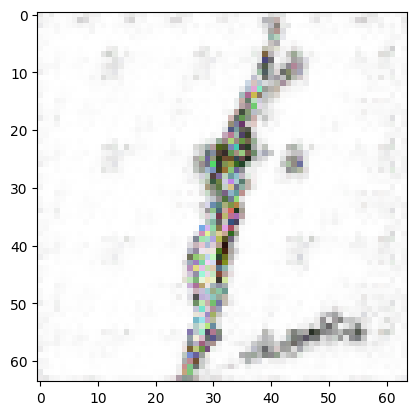

epoch 181 / 200, step 10 / 12, gen_loss = 12.0701, disc_loss = 0.5027
torch.Size([1, 4, 64, 64])
tensor([0.9899], device='cuda:0', grad_fn=<SqueezeBackward1>)


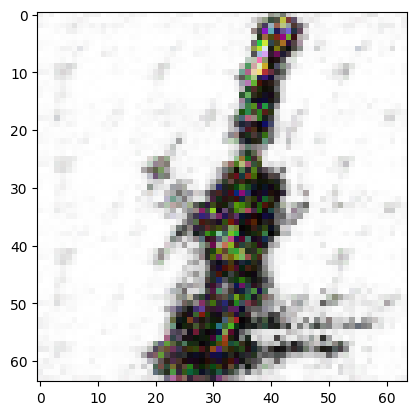

epoch 182 / 200, step 10 / 12, gen_loss = 0.9765, disc_loss = 0.5335
torch.Size([1, 4, 64, 64])
tensor([8.7695e-05], device='cuda:0', grad_fn=<SqueezeBackward1>)


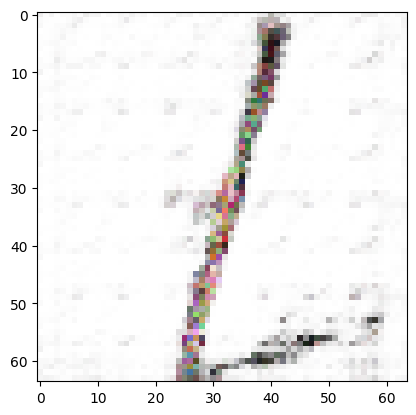

epoch 183 / 200, step 10 / 12, gen_loss = 6.0300, disc_loss = 0.3850
torch.Size([1, 4, 64, 64])
tensor([0.1038], device='cuda:0', grad_fn=<SqueezeBackward1>)


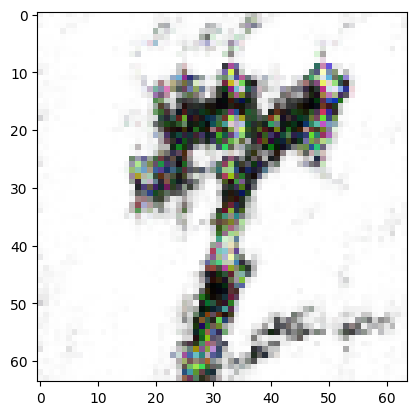

epoch 184 / 200, step 10 / 12, gen_loss = 6.4634, disc_loss = 0.0865
torch.Size([1, 4, 64, 64])
tensor([0.0295], device='cuda:0', grad_fn=<SqueezeBackward1>)


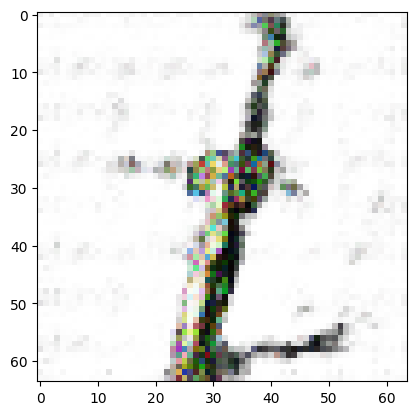

epoch 185 / 200, step 10 / 12, gen_loss = 7.0936, disc_loss = 0.2248
torch.Size([1, 4, 64, 64])
tensor([0.0076], device='cuda:0', grad_fn=<SqueezeBackward1>)


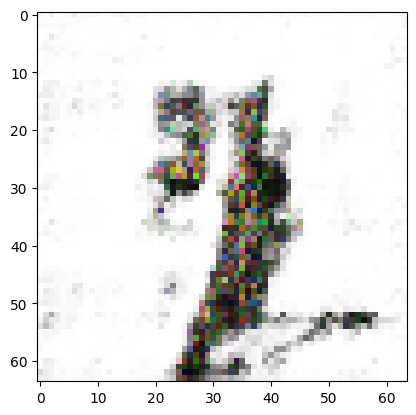

epoch 186 / 200, step 10 / 12, gen_loss = 4.4343, disc_loss = 0.2175
torch.Size([1, 4, 64, 64])
tensor([0.0794], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 187 / 200, step 10 / 12, gen_loss = 5.0538, disc_loss = 0.0815
torch.Size([1, 4, 64, 64])
tensor([0.0485], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 188 / 200, step 10 / 12, gen_loss = 5.0100, disc_loss = 0.1527
torch.Size([1, 4, 64, 64])
tensor([0.5483], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 189 / 200, step 10 / 12, gen_loss = 10.0141, disc_loss = 2.7855
torch.Size([1, 4, 64, 64])
tensor([0.1385], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 190 / 200, step 10 / 12, gen_loss = 4.4780, disc_loss = 0.1240
torch.Size([1, 4, 64, 64])
tensor([0.3866], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 191 / 200, step 10 / 12, gen_loss = 7.2934, disc_loss = 0.0430
torch.Size([1, 4, 64, 64])
tensor([0.0230], device='cuda:0', grad_fn=<SqueezeBackward1>)


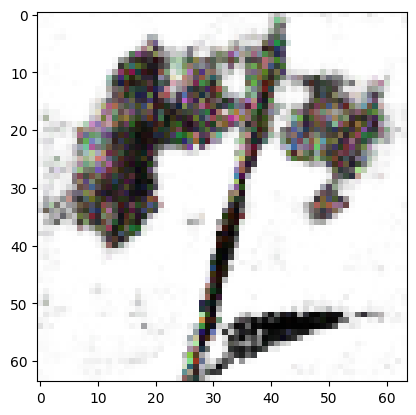

epoch 192 / 200, step 10 / 12, gen_loss = 9.5934, disc_loss = 0.6836
torch.Size([1, 4, 64, 64])
tensor([0.4303], device='cuda:0', grad_fn=<SqueezeBackward1>)


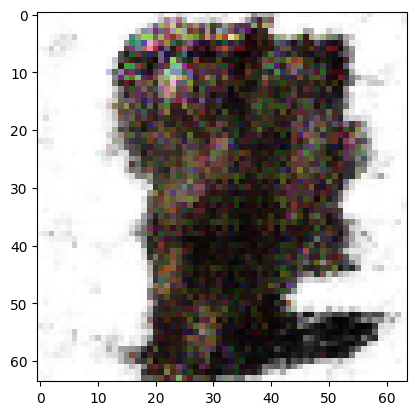

epoch 193 / 200, step 10 / 12, gen_loss = 3.6145, disc_loss = 0.2422
torch.Size([1, 4, 64, 64])
tensor([0.0235], device='cuda:0', grad_fn=<SqueezeBackward1>)


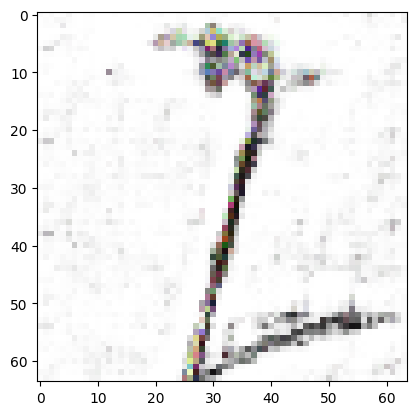

epoch 194 / 200, step 10 / 12, gen_loss = 5.7871, disc_loss = 0.4276
torch.Size([1, 4, 64, 64])
tensor([0.1378], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 195 / 200, step 10 / 12, gen_loss = 4.7635, disc_loss = 0.2509
torch.Size([1, 4, 64, 64])
tensor([0.0928], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 196 / 200, step 10 / 12, gen_loss = 4.6420, disc_loss = 0.0826
torch.Size([1, 4, 64, 64])
tensor([0.1614], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 197 / 200, step 10 / 12, gen_loss = 6.1954, disc_loss = 0.4572
torch.Size([1, 4, 64, 64])
tensor([0.2416], device='cuda:0', grad_fn=<SqueezeBackward1>)


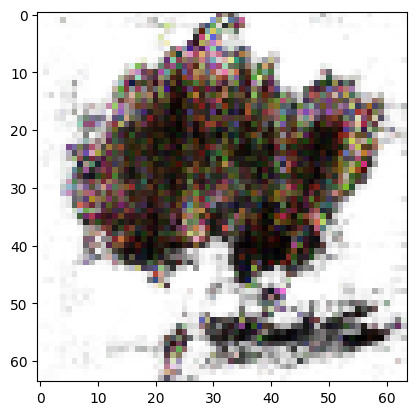

epoch 198 / 200, step 10 / 12, gen_loss = 4.6829, disc_loss = 0.1228
torch.Size([1, 4, 64, 64])
tensor([0.0066], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 199 / 200, step 10 / 12, gen_loss = 4.6207, disc_loss = 0.0891
torch.Size([1, 4, 64, 64])
tensor([0.0417], device='cuda:0', grad_fn=<SqueezeBackward1>)


epoch 200 / 200, step 10 / 12, gen_loss = 7.2544, disc_loss = 0.0458
torch.Size([1, 4, 64, 64])
tensor([0.0019], device='cuda:0', grad_fn=<SqueezeBackward1>)


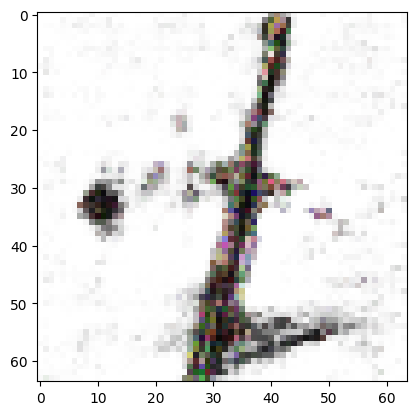

In [22]:
train_models()